In [837]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
from scipy.stats import norm

https://priodeep.weebly.com/uploads/6/5/4/9/65495087/craig_s_soil_mechanics_2_.pdf 
page 248

## Three layered cPINN with distributed variables

In [842]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [843]:
class cPINN_3layer_terzaghi(nn.Module):
    def __init__(self, hidden_size=50, hidden_layers=3, xavier=True):
        super().__init__()
        layers = [nn.Linear(11, hidden_size), nn.Tanh()] #t,z, H_1-n, k_1-n, mv_1-n
        for _ in range(hidden_layers):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
        if xavier:
            for layer in self.net:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    layer.bias.data.fill_(0.01)

    def forward(self, x):
        return self.net(x)

In [844]:
class ICWrapped(nn.Module):
    def __init__(self, core_net):
        super().__init__()
        self.core = core_net          # the old PINN you already built

    def forward(self, coords):
        t = coords[:, 0:1]            # first column is scaled time ∈ [0,1]
        N = self.core(coords)         # unconstrained output
        return (1.0 - t) + t * N      # û(t,z) = (1-t) + t·N


In [845]:
multiplier = 3.0
specs_info = [
    # name,   mean,           std,  lower_multiplier, upper_multiplier
    ("k1",     2e-2,          2e-3,    -multiplier,               multiplier), #[m/year]
    ("k2",     6e-3,         6e-4,    -multiplier,               multiplier), #[m/year]
    ("k3",     3e-3,          3e-4,  -multiplier,               multiplier), #[m/year]

    ("mv1",    4e-4,          4e-5,  -multiplier,               multiplier), #[m²/kN]
    ("mv2",    6e-4,          6e-5,    -multiplier,               multiplier), #[m²/kN]
    ("mv3",    7e-5,          7e-6,    -multiplier,               multiplier), #[m²/kN]

    # ("k1",     1.0e-4,       2e-5,    -multiplier,               multiplier), #[m/year]
    # ("k2",     1.0e-4,       2e-5,    -multiplier,               multiplier), #[m/year]
    # ("k3",     1.0e-4,       2e-5,    -multiplier,               multiplier), #[m/year]
    # ("mv1",    2e-5,         4e-6,    -multiplier,               multiplier), #[m²/kN]
    # ("mv2",    2e-5,         4e-6,    -multiplier,               multiplier), #[m²/kN]
    # ("mv3",    2e-5,         4e-6,    -multiplier,               multiplier), #[m²/kN]

    ("H1",     3.0,           1.0,    -0,               0), #[m]
    ("H2",     4.0,           1.0,     -0,               0), #[m]
    ("H3",     5.0,           1.0,    -0,               0), #[m]
]

specs = {
    "t": {"range": 10.0},     # years
    **{
        name: {
            "mean": mean,
            "std": std,
            "lower_multiplier": low,
            "upper_multiplier": up
        }
        for name, mean, std, low, up in specs_info
    }
}

In [846]:
# Generate random parameters
N=5000
H1 = torch.FloatTensor(N,1).uniform_(specs["H1"]["mean"] + specs["H1"]["lower_multiplier"] * specs["H1"]["std"],
                                     specs["H1"]["mean"] + specs["H1"]["upper_multiplier"] * specs["H1"]["std"])
H2 = torch.FloatTensor(N,1).uniform_(specs["H2"]["mean"] + specs["H2"]["lower_multiplier"] * specs["H2"]["std"],
                                     specs["H2"]["mean"] + specs["H2"]["upper_multiplier"] * specs["H2"]["std"])
H3 = torch.FloatTensor(N,1).uniform_(specs["H3"]["mean"] + specs["H3"]["lower_multiplier"] * specs["H3"]["std"],
                                     specs["H3"]["mean"] + specs["H3"]["upper_multiplier"] * specs["H3"]["std"])

k1 = torch.FloatTensor(N,1).uniform_(specs["k1"]["mean"] + specs["k1"]["lower_multiplier"] * specs["k1"]["std"],
                                     specs["k1"]["mean"] + specs["k1"]["upper_multiplier"] * specs["k1"]["std"])
k2 = torch.FloatTensor(N,1).uniform_(specs["k2"]["mean"] + specs["k2"]["lower_multiplier"] * specs["k2"]["std"],
                                     specs["k2"]["mean"] + specs["k2"]["upper_multiplier"] * specs["k2"]["std"])
k3 = torch.FloatTensor(N,1).uniform_(specs["k3"]["mean"] + specs["k3"]["lower_multiplier"] * specs["k3"]["std"],
                                     specs["k3"]["mean"] + specs["k3"]["upper_multiplier"] * specs["k3"]["std"])

mv1 = torch.FloatTensor(N,1).uniform_(specs["mv1"]["mean"] + specs["mv1"]["lower_multiplier"] * specs["mv1"]["std"],
                                     specs["mv1"]["mean"] + specs["mv1"]["upper_multiplier"] * specs["mv1"]["std"])
mv2 = torch.FloatTensor(N,1).uniform_(specs["mv2"]["mean"] + specs["mv2"]["lower_multiplier"] * specs["mv2"]["std"],
                                     specs["mv2"]["mean"] + specs["mv2"]["upper_multiplier"] * specs["mv2"]["std"])
mv3 = torch.FloatTensor(N,1).uniform_(specs["mv3"]["mean"] + specs["mv3"]["lower_multiplier"] * specs["mv3"]["std"],
                                     specs["mv3"]["mean"] + specs["mv3"]["upper_multiplier"] * specs["mv3"]["std"])

#Normalize
H1_norm = (H1 - specs["H1"]["mean"]) / (specs["H1"]["std"] * multiplier)
H2_norm = (H2 - specs["H2"]["mean"]) / (specs["H2"]["std"] * multiplier)
H3_norm = (H3 - specs["H3"]["mean"]) / (specs["H3"]["std"] * multiplier)
k1_norm = (k1 - specs["k1"]["mean"]) / (specs["k1"]["std"] * multiplier)
k2_norm = (k2 - specs["k2"]["mean"]) / (specs["k2"]["std"] * multiplier)
k3_norm = (k3 - specs["k3"]["mean"]) / (specs["k3"]["std"] * multiplier)
mv1_norm = (mv1 - specs["mv1"]["mean"]) / (specs["mv1"]["std"] * multiplier)
mv2_norm = (mv2 - specs["mv2"]["mean"]) / (specs["mv2"]["std"] * multiplier)
mv3_norm = (mv3 - specs["mv3"]["mean"]) / (specs["mv3"]["std"] * multiplier)

# z-values for each layer
H_tot = H1 + H2 + H3
z1 = (torch.rand(N, 1) * H1 / H_tot).requires_grad_(True)
z2 = (H1 / H_tot + torch.rand(N, 1) * (H2 / H_tot)).requires_grad_(True)
z3 = ((H1+H2) / H_tot + torch.rand(N, 1) * (H3 / H_tot)).requires_grad_(True)

# time values
t1 = torch.rand(N,1).requires_grad_(True)
t2 = torch.rand(N,1).requires_grad_(True)
t3 = torch.rand(N,1).requires_grad_(True)

# Concatenate inputs
domain_points_1 = torch.cat([t1, z1, 
                             H1_norm, k1_norm, mv1_norm, 
                             H2_norm, k2_norm, mv2_norm, 
                             H3_norm, k3_norm, mv3_norm
                             ], dim=1) # feed first layer model

domain_points_2 = torch.cat([t2, z2,
                             H1_norm, k1_norm, mv1_norm, 
                             H2_norm, k2_norm, mv2_norm, 
                             H3_norm, k3_norm, mv3_norm
                             ], dim=1) # feed second layer model
domain_points_3 = torch.cat([t3, z3,
                             H1_norm, k1_norm, mv1_norm, 
                             H2_norm, k2_norm, mv2_norm, 
                             H3_norm, k3_norm, mv3_norm
                             ], dim=1) # feed third layer model

#boundary points 
Nb = 1000

# z = 0
z_b0 = torch.zeros(Nb,1).requires_grad_(True)
t_b0 = torch.rand(Nb,1).requires_grad_(True)

H1_b0 = torch.FloatTensor(Nb,1).uniform_(specs["H1"]["mean"] + specs["H1"]["lower_multiplier"] * specs["H1"]["std"],
                                     specs["H1"]["mean"] + specs["H1"]["upper_multiplier"] * specs["H1"]["std"])
H2_b0 = torch.FloatTensor(Nb,1).uniform_(specs["H2"]["mean"] + specs["H2"]["lower_multiplier"] * specs["H2"]["std"],
                                     specs["H2"]["mean"] + specs["H2"]["upper_multiplier"] * specs["H2"]["std"])
H3_b0 = torch.FloatTensor(Nb,1).uniform_(specs["H3"]["mean"] + specs["H3"]["lower_multiplier"] * specs["H3"]["std"],
                                     specs["H3"]["mean"] + specs["H3"]["upper_multiplier"] * specs["H3"]["std"])

k1_b0 = torch.FloatTensor(Nb,1).uniform_(specs["k1"]["mean"] + specs["k1"]["lower_multiplier"] * specs["k1"]["std"],
                                     specs["k1"]["mean"] + specs["k1"]["upper_multiplier"] * specs["k1"]["std"])
k2_b0 = torch.FloatTensor(Nb,1).uniform_(specs["k2"]["mean"] + specs["k2"]["lower_multiplier"] * specs["k2"]["std"],
                                     specs["k2"]["mean"] + specs["k2"]["upper_multiplier"] * specs["k2"]["std"])
k3_b0 = torch.FloatTensor(Nb,1).uniform_(specs["k3"]["mean"] + specs["k3"]["lower_multiplier"] * specs["k3"]["std"],
                                     specs["k3"]["mean"] + specs["k3"]["upper_multiplier"] * specs["k3"]["std"])

mv1_b0 = torch.FloatTensor(Nb,1).uniform_(specs["mv1"]["mean"] + specs["mv1"]["lower_multiplier"] * specs["mv1"]["std"],
                                     specs["mv1"]["mean"] + specs["mv1"]["upper_multiplier"] * specs["mv1"]["std"])
mv2_b0 = torch.FloatTensor(Nb,1).uniform_(specs["mv2"]["mean"] + specs["mv2"]["lower_multiplier"] * specs["mv2"]["std"],
                                     specs["mv2"]["mean"] + specs["mv2"]["upper_multiplier"] * specs["mv2"]["std"])
mv3_b0 = torch.FloatTensor(Nb,1).uniform_(specs["mv3"]["mean"] + specs["mv3"]["lower_multiplier"] * specs["mv3"]["std"],
                                     specs["mv3"]["mean"] + specs["mv3"]["upper_multiplier"] * specs["mv3"]["std"])

#Normalize
H1_b0_norm = (H1_b0 - specs["H1"]["mean"]) / (specs["H1"]["std"] * multiplier)
H2_b0_norm = (H2_b0 - specs["H2"]["mean"]) / (specs["H2"]["std"] * multiplier)
H3_b0_norm = (H3_b0 - specs["H3"]["mean"]) / (specs["H3"]["std"] * multiplier)
k1_b0_norm = (k1_b0 - specs["k1"]["mean"]) / (specs["k1"]["std"] * multiplier)
k2_b0_norm = (k2_b0 - specs["k2"]["mean"]) / (specs["k2"]["std"] * multiplier)
k3_b0_norm = (k3_b0 - specs["k3"]["mean"]) / (specs["k3"]["std"] * multiplier)
mv1_b0_norm = (mv1_b0 - specs["mv1"]["mean"]) / (specs["mv1"]["std"] * multiplier)
mv2_b0_norm = (mv2_b0 - specs["mv2"]["mean"]) / (specs["mv2"]["std"] * multiplier)
mv3_b0_norm = (mv3_b0 - specs["mv3"]["mean"]) / (specs["mv3"]["std"] * multiplier)

boundary_points_b0 = torch.cat([t_b0, z_b0, 
                               H1_b0_norm, k1_b0_norm, mv1_b0_norm, 
                               H2_b0_norm, k2_b0_norm, mv2_b0_norm, 
                               H3_b0_norm, k3_b0_norm, mv3_b0_norm
                               ], dim=1) # feed first layer model

# z = 1
z_b1 = torch.ones(Nb,1).requires_grad_(True)
t_b1 = torch.rand(Nb,1).requires_grad_(True)

H1_b1 = torch.FloatTensor(Nb,1).uniform_(specs["H1"]["mean"] + specs["H1"]["lower_multiplier"] * specs["H1"]["std"],
                                     specs["H1"]["mean"] + specs["H1"]["upper_multiplier"] * specs["H1"]["std"])
H2_b1 = torch.FloatTensor(Nb,1).uniform_(specs["H2"]["mean"] + specs["H2"]["lower_multiplier"] * specs["H2"]["std"],
                                     specs["H2"]["mean"] + specs["H2"]["upper_multiplier"] * specs["H2"]["std"])
H3_b1 = torch.FloatTensor(Nb,1).uniform_(specs["H3"]["mean"] + specs["H3"]["lower_multiplier"] * specs["H3"]["std"],
                                     specs["H3"]["mean"] + specs["H3"]["upper_multiplier"] * specs["H3"]["std"])

k1_b1 = torch.FloatTensor(Nb,1).uniform_(specs["k1"]["mean"] + specs["k1"]["lower_multiplier"] * specs["k1"]["std"],
                                     specs["k1"]["mean"] + specs["k1"]["upper_multiplier"] * specs["k1"]["std"])
k2_b1 = torch.FloatTensor(Nb,1).uniform_(specs["k2"]["mean"] + specs["k2"]["lower_multiplier"] * specs["k2"]["std"],
                                     specs["k2"]["mean"] + specs["k2"]["upper_multiplier"] * specs["k2"]["std"])
k3_b1 = torch.FloatTensor(Nb,1).uniform_(specs["k3"]["mean"] + specs["k3"]["lower_multiplier"] * specs["k3"]["std"],
                                     specs["k3"]["mean"] + specs["k3"]["upper_multiplier"] * specs["k3"]["std"])

mv1_b1 = torch.FloatTensor(Nb,1).uniform_(specs["mv1"]["mean"] + specs["mv1"]["lower_multiplier"] * specs["mv1"]["std"],
                                     specs["mv1"]["mean"] + specs["mv1"]["upper_multiplier"] * specs["mv1"]["std"])
mv2_b1 = torch.FloatTensor(Nb,1).uniform_(specs["mv2"]["mean"] + specs["mv2"]["lower_multiplier"] * specs["mv2"]["std"],
                                     specs["mv2"]["mean"] + specs["mv2"]["upper_multiplier"] * specs["mv2"]["std"])
mv3_b1 = torch.FloatTensor(Nb,1).uniform_(specs["mv3"]["mean"] + specs["mv3"]["lower_multiplier"] * specs["mv3"]["std"],
                                     specs["mv3"]["mean"] + specs["mv3"]["upper_multiplier"] * specs["mv3"]["std"])

#Normalize
H1_b1_norm = (H1_b1 - specs["H1"]["mean"]) / (specs["H1"]["std"] * multiplier)
H2_b1_norm = (H2_b1 - specs["H2"]["mean"]) / (specs["H2"]["std"] * multiplier)
H3_b1_norm = (H3_b1 - specs["H3"]["mean"]) / (specs["H3"]["std"] * multiplier)
k1_b1_norm = (k1_b1 - specs["k1"]["mean"]) / (specs["k1"]["std"] * multiplier)
k2_b1_norm = (k2_b1 - specs["k2"]["mean"]) / (specs["k2"]["std"] * multiplier)
k3_b1_norm = (k3_b1 - specs["k3"]["mean"]) / (specs["k3"]["std"] * multiplier)
mv1_b1_norm = (mv1_b1 - specs["mv1"]["mean"]) / (specs["mv1"]["std"] * multiplier)
mv2_b1_norm = (mv2_b1 - specs["mv2"]["mean"]) / (specs["mv2"]["std"] * multiplier)
mv3_b1_norm = (mv3_b1 - specs["mv3"]["mean"]) / (specs["mv3"]["std"] * multiplier)

boundary_points_b1 = torch.cat([t_b1, z_b1, 
                               H1_b1_norm, k1_b1_norm, mv1_b1_norm, 
                               H2_b1_norm, k2_b1_norm, mv2_b1_norm, 
                               H3_b1_norm, k3_b1_norm, mv3_b1_norm
                               ], dim=1) # feed last layer model


#initial condition
Ni = 1000

H1_i = torch.FloatTensor(Ni,1).uniform_(specs["H1"]["mean"] + specs["H1"]["lower_multiplier"] * specs["H1"]["std"],
                                        specs["H1"]["mean"] + specs["H1"]["upper_multiplier"] * specs["H1"]["std"])
H2_i = torch.FloatTensor(Ni,1).uniform_(specs["H2"]["mean"] + specs["H2"]["lower_multiplier"] * specs["H2"]["std"],
                                        specs["H2"]["mean"] + specs["H2"]["upper_multiplier"] * specs["H2"]["std"])
H3_i = torch.FloatTensor(Ni,1).uniform_(specs["H3"]["mean"] + specs["H3"]["lower_multiplier"] * specs["H3"]["std"],
                                        specs["H3"]["mean"] + specs["H3"]["upper_multiplier"] * specs["H3"]["std"])

k1_i = torch.FloatTensor(Ni,1).uniform_(specs["k1"]["mean"] + specs["k1"]["lower_multiplier"] * specs["k1"]["std"],
                                        specs["k1"]["mean"] + specs["k1"]["upper_multiplier"] * specs["k1"]["std"])
k2_i = torch.FloatTensor(Ni,1).uniform_(specs["k2"]["mean"] + specs["k2"]["lower_multiplier"] * specs["k2"]["std"],
                                        specs["k2"]["mean"] + specs["k2"]["upper_multiplier"] * specs["k2"]["std"])
k3_i = torch.FloatTensor(Ni,1).uniform_(specs["k3"]["mean"] + specs["k3"]["lower_multiplier"] * specs["k3"]["std"],
                                        specs["k3"]["mean"] + specs["k3"]["upper_multiplier"] * specs["k3"]["std"])

mv1_i = torch.FloatTensor(Ni,1).uniform_(specs["mv1"]["mean"] + specs["mv1"]["lower_multiplier"] * specs["mv1"]["std"],
                                         specs["mv1"]["mean"] + specs["mv1"]["upper_multiplier"] * specs["mv1"]["std"])
mv2_i = torch.FloatTensor(Ni,1).uniform_(specs["mv2"]["mean"] + specs["mv2"]["lower_multiplier"] * specs["mv2"]["std"],
                                         specs["mv2"]["mean"] + specs["mv2"]["upper_multiplier"] * specs["mv2"]["std"])
mv3_i = torch.FloatTensor(Ni,1).uniform_(specs["mv3"]["mean"] + specs["mv3"]["lower_multiplier"] * specs["mv3"]["std"],
                                         specs["mv3"]["mean"] + specs["mv3"]["upper_multiplier"] * specs["mv3"]["std"])

# Normalize
H1_i_norm = (H1_i - specs["H1"]["mean"]) / (specs["H1"]["std"] * multiplier)
H2_i_norm = (H2_i - specs["H2"]["mean"]) / (specs["H2"]["std"] * multiplier)
H3_i_norm = (H3_i - specs["H3"]["mean"]) / (specs["H3"]["std"] * multiplier)
k1_i_norm = (k1_i - specs["k1"]["mean"]) / (specs["k1"]["std"] * multiplier)
k2_i_norm = (k2_i - specs["k2"]["mean"]) / (specs["k2"]["std"] * multiplier)
k3_i_norm = (k3_i - specs["k3"]["mean"]) / (specs["k3"]["std"] * multiplier)
mv1_i_norm = (mv1_i - specs["mv1"]["mean"]) / (specs["mv1"]["std"] * multiplier)
mv2_i_norm = (mv2_i - specs["mv2"]["mean"]) / (specs["mv2"]["std"] * multiplier)
mv3_i_norm = (mv3_i - specs["mv3"]["mean"]) / (specs["mv3"]["std"] * multiplier)

# z-values for each layer
H_tot_i = H1_i + H2_i + H3_i
z1_i = (torch.rand(Ni, 1) * H1_i / H_tot_i).requires_grad_(True)
z2_i = (H1_i / H_tot_i + torch.rand(Ni, 1) * (H2_i / H_tot_i)).requires_grad_(True)
z3_i = ((H1_i+H2_i) / H_tot_i + torch.rand(Ni, 1) * (H3_i / H_tot_i)).requires_grad_(True)

# time values
t_i = torch.zeros(Ni,1).requires_grad_(True)

# Concatenate inputs
initial_points_1 = torch.cat([t_i, z1_i, 
                               H1_i_norm, k1_i_norm, mv1_i_norm, 
                               H2_i_norm, k2_i_norm, mv2_i_norm, 
                               H3_i_norm, k3_i_norm, mv3_i_norm
                               ], dim=1) # feed first layer model

initial_points_2 = torch.cat([t_i, z2_i,
                               H1_i_norm, k1_i_norm, mv1_i_norm, 
                               H2_i_norm, k2_i_norm, mv2_i_norm, 
                               H3_i_norm, k3_i_norm, mv3_i_norm
                               ], dim=1) # feed second layer model
initial_points_3 = torch.cat([t_i, z3_i,
                               H1_i_norm, k1_i_norm, mv1_i_norm, 
                               H2_i_norm, k2_i_norm, mv2_i_norm, 
                               H3_i_norm, k3_i_norm, mv3_i_norm
                               ], dim=1) # feed third layer model


# Interface points
Nif = 1000

#  Interface 1-2
H1_if_12 = torch.FloatTensor(Nif, 1).uniform_(specs["H1"]["mean"] + specs["H1"]["lower_multiplier"] * specs["H1"]["std"], 
                                              specs["H1"]["mean"] + specs["H1"]["upper_multiplier"] * specs["H1"]["std"])
H2_if_12 = torch.FloatTensor(Nif, 1).uniform_(specs["H2"]["mean"] + specs["H2"]["lower_multiplier"] * specs["H2"]["std"], 
                                              specs["H2"]["mean"] + specs["H2"]["upper_multiplier"] * specs["H2"]["std"])
H3_if_12 = torch.FloatTensor(Nif, 1).uniform_(specs["H3"]["mean"] + specs["H3"]["lower_multiplier"] * specs["H3"]["std"], 
                                              specs["H3"]["mean"] + specs["H3"]["upper_multiplier"] * specs["H3"]["std"])

k1_if_12 = torch.FloatTensor(Nif, 1).uniform_(specs["k1"]["mean"] + specs["k1"]["lower_multiplier"] * specs["k1"]["std"], 
                                              specs["k1"]["mean"] + specs["k1"]["upper_multiplier"] * specs["k1"]["std"])
k2_if_12 = torch.FloatTensor(Nif, 1).uniform_(specs["k2"]["mean"] + specs["k2"]["lower_multiplier"] * specs["k2"]["std"], 
                                              specs["k2"]["mean"] + specs["k2"]["upper_multiplier"] * specs["k2"]["std"])
k3_if_12 = torch.FloatTensor(Nif, 1).uniform_(specs["k3"]["mean"] + specs["k3"]["lower_multiplier"] * specs["k3"]["std"], 
                                              specs["k3"]["mean"] + specs["k3"]["upper_multiplier"] * specs["k3"]["std"])

mv1_if_12 = torch.FloatTensor(Nif, 1).uniform_(specs["mv1"]["mean"] + specs["mv1"]["lower_multiplier"] * specs["mv1"]["std"], 
                                               specs["mv1"]["mean"] + specs["mv1"]["upper_multiplier"] * specs["mv1"]["std"])
mv2_if_12 = torch.FloatTensor(Nif, 1).uniform_(specs["mv2"]["mean"] + specs["mv2"]["lower_multiplier"] * specs["mv2"]["std"], 
                                               specs["mv2"]["mean"] + specs["mv2"]["upper_multiplier"] * specs["mv2"]["std"])
mv3_if_12 = torch.FloatTensor(Nif, 1).uniform_(specs["mv3"]["mean"] + specs["mv3"]["lower_multiplier"] * specs["mv3"]["std"], 
                                               specs["mv3"]["mean"] + specs["mv3"]["upper_multiplier"] * specs["mv3"]["std"])

# Normalize
H1_if_12_norm = (H1_if_12 - specs["H1"]["mean"]) / (specs["H1"]["std"] * multiplier)
H2_if_12_norm = (H2_if_12 - specs["H2"]["mean"]) / (specs["H2"]["std"] * multiplier)
H3_if_12_norm = (H3_if_12 - specs["H3"]["mean"]) / (specs["H3"]["std"] * multiplier)
k1_if_12_norm = (k1_if_12 - specs["k1"]["mean"]) / (specs["k1"]["std"] * multiplier)
k2_if_12_norm = (k2_if_12 - specs["k2"]["mean"]) / (specs["k2"]["std"] * multiplier)
k3_if_12_norm = (k3_if_12 - specs["k3"]["mean"]) / (specs["k3"]["std"] * multiplier)
mv1_if_12_norm = (mv1_if_12 - specs["mv1"]["mean"]) / (specs["mv1"]["std"] * multiplier)
mv2_if_12_norm = (mv2_if_12 - specs["mv2"]["mean"]) / (specs["mv2"]["std"] * multiplier)
mv3_if_12_norm = (mv3_if_12 - specs["mv3"]["mean"]) / (specs["mv3"]["std"] * multiplier)

H_tot_if_12 = H1_if_12 + H2_if_12 + H3_if_12
z_if_12 = (H1_if_12 / H_tot_if_12).requires_grad_(True)

t_if_12 = torch.rand(Nif, 1).requires_grad_(True)

interface_points_12 = torch.cat([
    t_if_12, z_if_12,
    H1_if_12_norm, k1_if_12_norm, mv1_if_12_norm,
    H2_if_12_norm, k2_if_12_norm, mv2_if_12_norm,
    H3_if_12_norm, k3_if_12_norm, mv3_if_12_norm
], dim=1)

# Interface 1-3

H1_if_23 = torch.FloatTensor(Nif, 1).uniform_(specs["H1"]["mean"] + specs["H1"]["lower_multiplier"] * specs["H1"]["std"], 
                                              specs["H1"]["mean"] + specs["H1"]["upper_multiplier"] * specs["H1"]["std"])
H2_if_23 = torch.FloatTensor(Nif, 1).uniform_(specs["H2"]["mean"] + specs["H2"]["lower_multiplier"] * specs["H2"]["std"], 
                                              specs["H2"]["mean"] + specs["H2"]["upper_multiplier"] * specs["H2"]["std"])
H3_if_23 = torch.FloatTensor(Nif, 1).uniform_(specs["H3"]["mean"] + specs["H3"]["lower_multiplier"] * specs["H3"]["std"], 
                                              specs["H3"]["mean"] + specs["H3"]["upper_multiplier"] * specs["H3"]["std"])

k1_if_23 = torch.FloatTensor(Nif, 1).uniform_(specs["k1"]["mean"] + specs["k1"]["lower_multiplier"] * specs["k1"]["std"], 
                                              specs["k1"]["mean"] + specs["k1"]["upper_multiplier"] * specs["k1"]["std"])
k2_if_23 = torch.FloatTensor(Nif, 1).uniform_(specs["k2"]["mean"] + specs["k2"]["lower_multiplier"] * specs["k2"]["std"], 
                                              specs["k2"]["mean"] + specs["k2"]["upper_multiplier"] * specs["k2"]["std"])
k3_if_23 = torch.FloatTensor(Nif, 1).uniform_(specs["k3"]["mean"] + specs["k3"]["lower_multiplier"] * specs["k3"]["std"], 
                                              specs["k3"]["mean"] + specs["k3"]["upper_multiplier"] * specs["k3"]["std"])

mv1_if_23 = torch.FloatTensor(Nif, 1).uniform_(specs["mv1"]["mean"] + specs["mv1"]["lower_multiplier"] * specs["mv1"]["std"], 
                                               specs["mv1"]["mean"] + specs["mv1"]["upper_multiplier"] * specs["mv1"]["std"])
mv2_if_23 = torch.FloatTensor(Nif, 1).uniform_(specs["mv2"]["mean"] + specs["mv2"]["lower_multiplier"] * specs["mv2"]["std"], 
                                               specs["mv2"]["mean"] + specs["mv2"]["upper_multiplier"] * specs["mv2"]["std"])
mv3_if_23 = torch.FloatTensor(Nif, 1).uniform_(specs["mv3"]["mean"] + specs["mv3"]["lower_multiplier"] * specs["mv3"]["std"], 
                                               specs["mv3"]["mean"] + specs["mv3"]["upper_multiplier"] * specs["mv3"]["std"])

# Normalize
H1_if_23_norm = (H1_if_23 - specs["H1"]["mean"]) / (specs["H1"]["std"] * multiplier)
H2_if_23_norm = (H2_if_23 - specs["H2"]["mean"]) / (specs["H2"]["std"] * multiplier)
H3_if_23_norm = (H3_if_23 - specs["H3"]["mean"]) / (specs["H3"]["std"] * multiplier)
k1_if_23_norm = (k1_if_23 - specs["k1"]["mean"]) / (specs["k1"]["std"] * multiplier)
k2_if_23_norm = (k2_if_23 - specs["k2"]["mean"]) / (specs["k2"]["std"] * multiplier)
k3_if_23_norm = (k3_if_23 - specs["k3"]["mean"]) /  (specs["k3"]["std"] * multiplier)
mv1_if_23_norm = (mv1_if_23 - specs["mv1"]["mean"]) / (specs["mv1"]["std"] * multiplier)
mv2_if_23_norm = (mv2_if_23 - specs["mv2"]["mean"]) / (specs["mv2"]["std"] * multiplier)
mv3_if_23_norm = (mv3_if_23 - specs["mv3"]["mean"]) / (specs["mv3"]["std"] * multiplier)

H_tot_if_23 = H1_if_23 + H2_if_23 + H3_if_23
z_if_23 = ((H1_if_23 + H2_if_23) / H_tot_if_23).requires_grad_(True)

t_if_23 = torch.rand(Nif, 1).requires_grad_(True)

interface_points_23 = torch.cat([
    t_if_23, z_if_23,
    H1_if_23_norm, k1_if_23_norm, mv1_if_23_norm,
    H2_if_23_norm, k2_if_23_norm, mv2_if_23_norm,
    H3_if_23_norm, k3_if_23_norm, mv3_if_23_norm
], dim=1)

print("domain_points_1", H1.min(), k1_norm.min(), mv1_norm.min())
print("domain_points_2", H2_norm.min(), k2_norm.min(), mv2_norm.min())
print("domain_points_3", H3_norm.min(), k3_norm.min(), mv3_norm.min())
print("boundary_points_b0", H1_b0_norm.min(), k1_b0_norm.min(), mv1_b0_norm.min())
print("boundary_points_b1", H1_b1_norm.min(), k1_b1_norm.min(), mv1_b1_norm.min())
print("initial_points_1", H1_i_norm.min(), k1_i_norm.min(), mv1_i_norm.min())
print("initial_points_2", H2_i_norm.min(), k2_i_norm.min(), mv2_i_norm.min())
print("initial_points_3", H3_i_norm.min(), k3_i_norm.min(), mv3_i_norm.min())
print("interface_points_12", H1_if_12_norm.min(), k1_if_12_norm.min(), mv1_if_12_norm.min())
print("interface_points_23", H1_if_23_norm.min(), k1_if_23_norm.min(), mv1_if_23_norm.min())

print(t_if_23.min(), z_if_23.min(),
    H1_if_23_norm.max(), k1_if_23_norm.max(), mv1_if_23_norm.max(),
    H2_if_23_norm.max(), k2_if_23_norm.max(), mv2_if_23_norm.max(),
    H3_if_23_norm.max(), k3_if_23_norm.max(), mv3_if_23_norm.max())
print(t_if_12.min(), z_if_12.min(),
    H1_if_12_norm.max(), k1_if_12_norm.max(), mv1_if_12_norm.max(),
    H2_if_12_norm.max(), k2_if_12_norm.max(), mv2_if_12_norm.max(),
    H3_if_12_norm.max(), k3_if_12_norm.max(), mv3_if_12_norm.max())
print(t_b0.min(), z_b0.min(),
    H1_b0_norm.max(), k1_b0_norm.max(), mv1_b0_norm.max(),
    H2_b0_norm.max(), k2_b0_norm.max(), mv2_b0_norm.max(),
    H3_b0_norm.max(), k3_b0_norm.max(), mv3_b0_norm.max())
print(t_b1.min(), z_b1.min(),
    H1_b1_norm.max(), k1_b1_norm.max(), mv1_b1_norm.max(),
    H2_b1_norm.max(), k2_b1_norm.max(), mv2_b1_norm.max(),
    H3_b1_norm.max(), k3_b1_norm.max(), mv3_b1_norm.max())
print(z1.min(), z1.max())
print(z2.min(), z2.max())
print(z3.min(), z3.max())


domain_points_1 tensor(3.) tensor(-0.9996) tensor(-1.0000)
domain_points_2 tensor(0.) tensor(-0.9989) tensor(-0.9997)
domain_points_3 tensor(0.) tensor(-0.9998) tensor(-0.9999)
boundary_points_b0 tensor(0.) tensor(-0.9992) tensor(-0.9988)
boundary_points_b1 tensor(0.) tensor(-0.9998) tensor(-0.9991)
initial_points_1 tensor(0.) tensor(-0.9986) tensor(-0.9955)
initial_points_2 tensor(0.) tensor(-0.9992) tensor(-0.9974)
initial_points_3 tensor(0.) tensor(-1.0000) tensor(-0.9972)
interface_points_12 tensor(0.) tensor(-0.9972) tensor(-0.9993)
interface_points_23 tensor(0.) tensor(-0.9967) tensor(-0.9969)
tensor(0.0006, grad_fn=<MinBackward1>) tensor(0.5833, grad_fn=<MinBackward1>) tensor(0.) tensor(0.9996) tensor(0.9969) tensor(0.) tensor(0.9998) tensor(0.9999) tensor(0.) tensor(0.9998) tensor(0.9977)
tensor(3.4571e-05, grad_fn=<MinBackward1>) tensor(0.2500, grad_fn=<MinBackward1>) tensor(0.) tensor(0.9945) tensor(0.9954) tensor(0.) tensor(0.9993) tensor(0.9961) tensor(0.) tensor(0.9990) te

In [847]:
print(mv3_norm)

tensor([[ 0.7591],
        [ 0.3946],
        [-0.5299],
        ...,
        [-0.1911],
        [-0.4322],
        [-0.1081]])


In [848]:
def terzaghi_residual_1(model, coords, specs):
    """
    Compute the residual of the Terzaghi consolidation equation
    for layer 1, given coords = [t, z, H1, k1, mv1, H2, k2, mv2, H3, k3, mv3].
    """

    # denormalized parameters
    T_phys = specs["t"]["range"] #years
    H1 = coords[:,2:3] * specs["H1"]["std"] * multiplier + specs["H1"]["mean"]
    k1 = coords[:,3:4] * specs["k1"]["std"] * multiplier + specs["k1"]["mean"]
    mv1 = coords[:,4:5] * specs["mv1"]["std"] * multiplier + specs["mv1"]["mean"]
    H2 = coords[:,5:6] * specs["H2"]["std"] * multiplier + specs["H2"]["mean"]
    H3 = coords[:,8:9] * specs["H3"]["std"] * multiplier + specs["H3"]["mean"]

    yw = 9.81  # kN/m³
    H_tot = H1 + H2 + H3
    cv = (k1 / (mv1 *yw)) * T_phys / H_tot**2 # *10years / H_tot to get correct scale
    # incoords = coords[:, 0:2]
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:,0:1]
    u_z = grads[:,1:1+1]
    u_zz = torch.autograd.grad(u_z, coords, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:,1:1+1]

    # Terzaghi consolidation equation
    residual = u_t - cv * u_zz
    return torch.mean(residual**2)

def terzaghi_residual_2(model, coords, specs):
    """
    Compute the residual of the Terzaghi consolidation equation
    for layer 2, given coords = [t, z, H1, k1, mv1, H2, k2, mv2, H3, k3, mv3].
    """

    # denormalized parameters
    T_phys = specs["t"]["range"] #years
    H1 = coords[:,2:3] * specs["H1"]["std"] * multiplier + specs["H1"]["mean"]
    H2 = coords[:,5:6] * specs["H2"]["std"] * multiplier + specs["H2"]["mean"]
    k2 = coords[:,6:7] * specs["k2"]["std"] * multiplier + specs["k2"]["mean"]
    mv2 = coords[:,7:8] * specs["mv2"]["std"] * multiplier + specs["mv2"]["mean"]
    H3 = coords[:,8:9] * specs["H3"]["std"] * multiplier + specs["H3"]["mean"]

    yw = 9.81  # kN/m³
    H_tot = H1 + H2 + H3
    cv = (k2 / (mv2 *yw))*T_phys/H_tot**2 # *10years / H_tot to get correct scale
    # incoords = coords[:, 0:2]
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:,0:1]
    u_z = grads[:,1:2]
    u_zz = torch.autograd.grad(u_z, coords, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:,1:1+1]

    # Terzaghi consolidation equation
    residual = u_t - cv * u_zz
    return torch.mean(residual**2)

def terzaghi_residual_3(model, coords, specs):
    """
    Compute the residual of the Terzaghi consolidation equation
    for layer 3, given coords = [t, z, H1, k1, mv1, H2, k2, mv2, H3, k3, mv3].
    """

    # denormalized parameters
    T_phys = specs["t"]["range"] #years
    H1 = coords[:,2:3] * specs["H1"]["std"] * multiplier + specs["H1"]["mean"]
    H2 = coords[:,5:6] * specs["H2"]["std"] * multiplier + specs["H2"]["mean"]
    H3 = coords[:,8:9] * specs["H3"]["std"] * multiplier + specs["H3"]["mean"]
    k3 = coords[:,9:10] * specs["k3"]["std"] * multiplier + specs["k3"]["mean"]
    mv3 = coords[:,10:11] * specs["mv3"]["std"] * multiplier + specs["mv3"]["mean"]

    yw = 9.81  # kN/m³
    H_tot = H1 + H2 + H3
    cv = (k3 / (mv3 *yw))*T_phys/H_tot**2 # *10years / H_tot to get correct scale
    # incoords = coords[:, 0:2]
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:,0:1]
    u_z = grads[:,1:2]
    u_zz = torch.autograd.grad(u_z, coords, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:,1:1+1]

    # Terzaghi consolidation equation
    residual = u_t - cv * u_zz
    return torch.mean(residual**2)

In [849]:
def terzaghi_boundary_0(model, coords):
    # incoords = coords[:, 0:2]
    u = model(coords)
    return torch.mean(u**2)

def terzaghi_boundary_1(model, coords):
    # incoords = coords[:, 0:2]
    u = model(coords)

    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_z = grads[:,1:2]
    return torch.mean(u_z**2)

def terzaghi_initial(model, coords):
    # incoords = coords[:, 0:2]
    u = model(coords)
    return torch.mean((u-1.0)**2)

def terzaghi_interface_12(model1, model2, coords):
    # incoords = coords[:, 0:2]
    u1 = model1(coords)
    u2 = model2(coords)
    continuity_loss = torch.mean((u1-u2)**2)

    u1_z = torch.autograd.grad(u1, coords, grad_outputs=torch.ones_like(u1), create_graph=True)[0][:,1:2]

    u2_z = torch.autograd.grad(u2, coords, grad_outputs=torch.ones_like(u2), create_graph=True)[0][:,1:2]

    k1 = coords[:,3:4] * specs["k1"]["std"] * multiplier + specs["k1"]["mean"]   # denormalise
    k2 = coords[:,6:7] * specs["k2"]["std"] * multiplier + specs["k2"]["mean"]
    flux1 = k1 * u1_z
    flux2 = k2 * u2_z

    scaling = (k1 * k2)**0.5

    flux_loss = torch.mean(((flux1-flux2)/scaling)**2)

    return continuity_loss, flux_loss

def terzaghi_interface_23(model2, model3, coords):
    # incoords = coords[:, 0:2]
    u2 = model2(coords)
    u3 = model3(coords)
    continuity_loss = torch.mean((u2-u3)**2)

    u2_z = torch.autograd.grad(u2, coords, grad_outputs=torch.ones_like(u2), create_graph=True)[0][:,1:2]

    u3_z = torch.autograd.grad(u3, coords, grad_outputs=torch.ones_like(u3), create_graph=True)[0][:,1:2]

    k2 = coords[:,6:7] * specs["k2"]["std"] * multiplier + specs["k2"]["mean"]   # denormalise
    k3 = coords[:,9:10] * specs["k3"]["std"] * multiplier + specs["k3"]["mean"]
    flux1 = k2 * u2_z
    flux2 = k3 * u3_z

    scaling = (k2 * k3)**0.5

    flux_loss = torch.mean(((flux1-flux2)/(scaling))**2)

    return continuity_loss, flux_loss

In [850]:
def plot_loss(losses_dict):
    plt.figure(figsize=(5, 3))
    # Find the maximum length among non-empty loss lists
    total_epochs = max((len(v) for v in losses_dict.values()), default=0)

    for loss_name, loss_values in losses_dict.items():
        n = len(loss_values)
        if n == 0:
            continue  # skip empty losses

        # If this curve is shorter than the longest one, offset it to the right
        if n < total_epochs:
            offset = total_epochs - n
            x = range(offset, offset + n)
        else:
            x = range(n)

        plt.plot(x, loss_values, label=loss_name)

    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [851]:
import os
if os.path.exists("loss_history.npy"):
    os.remove("loss_history.npy")


In [852]:
# weights
w = {
  'pde1':1, 'pde2':1, 'pde3':1,
  'b0':10, 'b1':1,
  'ic':1,
  'if_cont1':1, 'if_flux1':1e0,
  'if_cont2':1, 'if_flux2':1e0
}

if os.path.exists("loss_history.npy"): 
  losses = np.load("loss_history.npy", allow_pickle=True).tolist()
else:
  losses = {"Residual Loss 1": [],
            "Residual Loss 2": [],
            "Residual Loss 3": [],
            "Boundary Loss 0": [],
            "Boundary Loss 1": [],
            "Initial Loss  1": [],
            "Initial Loss  2": [],
            "Initial Loss  3": [],
            "Interface Cont Loss 12": [],
            "Interface Flux Loss 12": [],
            "Interface Cont Loss 23": [],
            "Interface Flux Loss 23": []}

# Initialize best loss so far
# if all three lists are empty, use +∞
if not any(losses.values()):
  best_loss = float("inf")
else:
  # otherwise grab last entry or 0.0
  residual_loss_1 = losses["Residual Loss 1"][-1] if losses["Residual Loss 1"] else 0.0
  residual_loss_2 = losses["Residual Loss 2"][-1] if losses["Residual Loss 2"] else 0.0
  residual_loss_3 = losses["Residual Loss 3"][-1] if losses["Residual Loss 3"] else 0.0
  boundary_loss_0 = losses["Boundary Loss 0"][-1] if losses["Boundary Loss 0"] else 0.0
  boundary_loss_1 = losses["Boundary Loss 1"][-1] if losses["Boundary Loss 1"] else 0.0
  initial_loss_1 = losses["Initial Loss  1"][-1] if losses["Initial Loss  1"] else 0.0
  initial_loss_2 = losses["Initial Loss  2"][-1] if losses["Initial Loss  2"] else 0.0
  initial_loss_3 = losses["Initial Loss  3"][-1] if losses["Initial Loss  3"] else 0.0
  cont_loss_12 = losses["Interface Cont Loss 12"][-1] if losses["Interface Cont Loss 12"] else 0.0
  flux_loss_12 = losses["Interface Flux Loss 12"][-1] if losses["Interface Flux Loss 12"] else 0.0
  cont_loss_23 = losses["Interface Cont Loss 23"][-1] if losses["Interface Cont Loss 23"] else 0.0
  flux_loss_23 = losses["Interface Flux Loss 23"][-1] if losses["Interface Flux Loss 23"] else 0.0

  best_loss = residual_loss_1*w['pde1'] + \
              residual_loss_2*w['pde2'] + \
              residual_loss_3*w['pde3'] + \
              boundary_loss_0*w['b0'] + \
              boundary_loss_1*w['b1'] + \
              initial_loss_1*w['ic'] + \
              initial_loss_2*w['ic'] + \
              initial_loss_3*w['ic'] + \
              cont_loss_12*w['if_cont1'] + \
              flux_loss_12*w['if_flux1'] + \
              cont_loss_23*w['if_cont2'] + \
              flux_loss_23*w['if_flux2']

In [853]:
raw_model1 = cPINN_3layer_terzaghi()
raw_model2 = cPINN_3layer_terzaghi()
raw_model3 = cPINN_3layer_terzaghi()

model1_trick = (raw_model1)
model2_trick = (raw_model2)
model3_trick = (raw_model3)


optimizer_adam = optim.Adam(
    list(model1_trick.parameters()) +
    list(model2_trick.parameters()) +
    list(model3_trick.parameters()),
    lr=1e-3
)

Epoch 0: Residual Loss 1: 1.9937e-02, Residual Loss 2: 4.6547e-03, Residual Loss 3: 6.1419e-03, Boundary Loss 0: 6.5001e-02, Boundary Loss 1: 5.8634e-02, Initial Loss 1: 8.7031e-01, Initial Loss 2: 9.5377e-01, Initial Loss 3: 1.5155e+00, Interface Cont Loss 12: 2.0000e-01, Interface Flux Loss 12: 1.5733e-01, Interface Cont Loss 23: 1.9465e-01, Interface Flux Loss 23: 7.4379e-02, Total Loss: 4.7053e+00


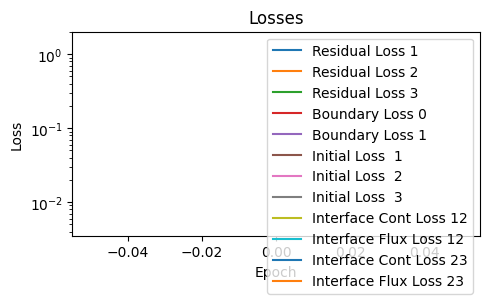

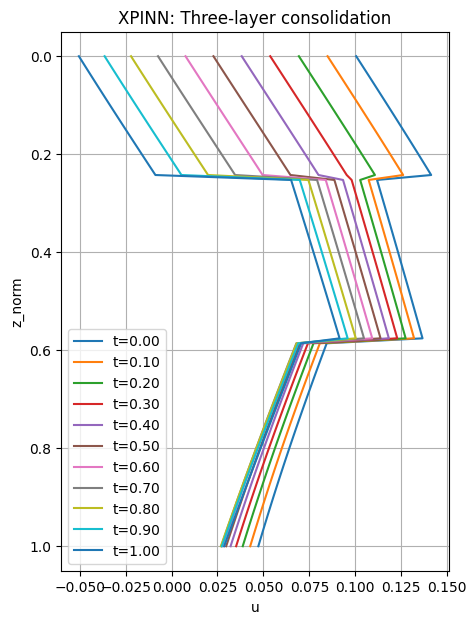

Epoch 500: Residual Loss 1: 1.0014e-02, Residual Loss 2: 7.0501e-03, Residual Loss 3: 2.7198e-03, Boundary Loss 0: 3.1609e-03, Boundary Loss 1: 3.9596e-03, Initial Loss 1: 7.6991e-02, Initial Loss 2: 7.1209e-03, Initial Loss 3: 2.3528e-04, Interface Cont Loss 12: 1.3091e-02, Interface Flux Loss 12: 1.2486e-02, Interface Cont Loss 23: 1.5863e-03, Interface Flux Loss 23: 6.7001e-03, Total Loss: 1.7356e-01


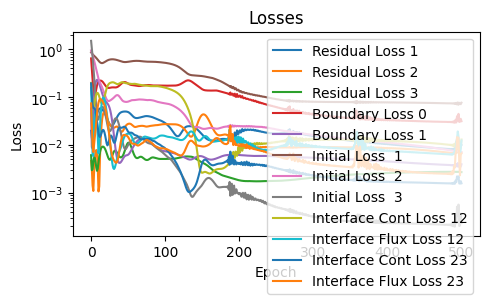

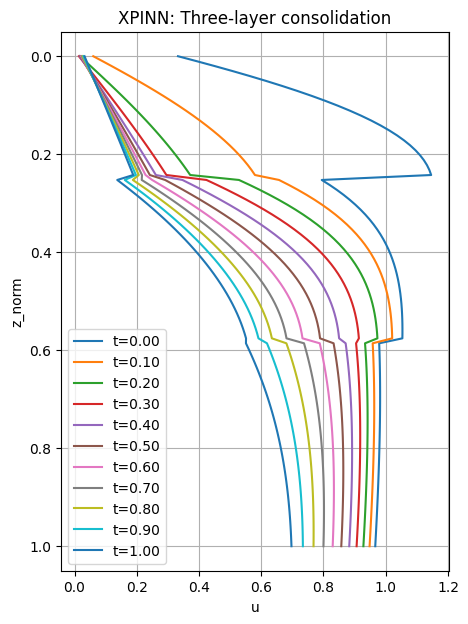

Epoch 1000: Residual Loss 1: 5.3015e-03, Residual Loss 2: 4.3890e-03, Residual Loss 3: 1.6370e-03, Boundary Loss 0: 2.2860e-03, Boundary Loss 1: 1.6545e-03, Initial Loss 1: 4.6462e-02, Initial Loss 2: 4.1779e-04, Initial Loss 3: 2.2226e-04, Interface Cont Loss 12: 1.3407e-03, Interface Flux Loss 12: 3.5123e-03, Interface Cont Loss 23: 1.1028e-03, Interface Flux Loss 23: 1.1400e-03, Total Loss: 9.0040e-02


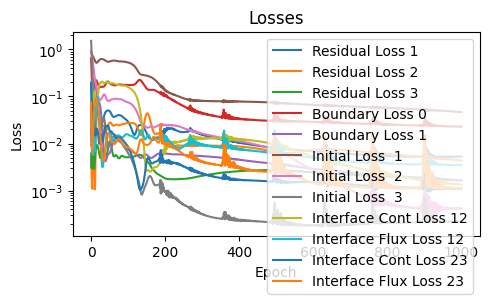

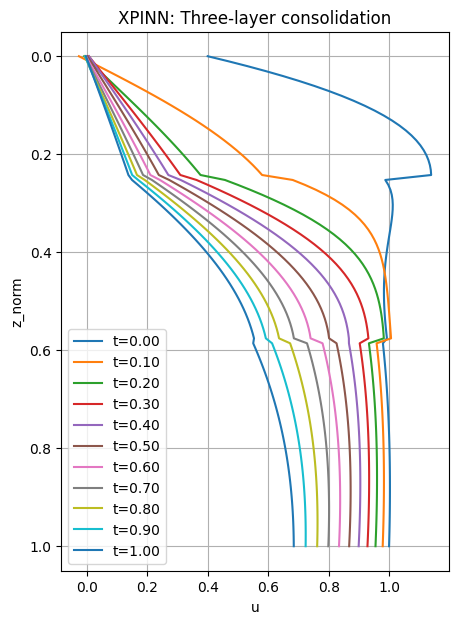

Epoch 1500: Residual Loss 1: 5.3428e-03, Residual Loss 2: 2.5064e-03, Residual Loss 3: 5.9583e-04, Boundary Loss 0: 1.4697e-03, Boundary Loss 1: 8.2036e-04, Initial Loss 1: 2.4884e-02, Initial Loss 2: 3.9075e-04, Initial Loss 3: 1.9152e-04, Interface Cont Loss 12: 7.4415e-04, Interface Flux Loss 12: 2.7391e-03, Interface Cont Loss 23: 9.5543e-04, Interface Flux Loss 23: 1.2049e-03, Total Loss: 5.5072e-02


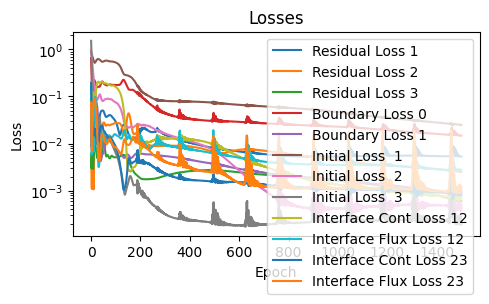

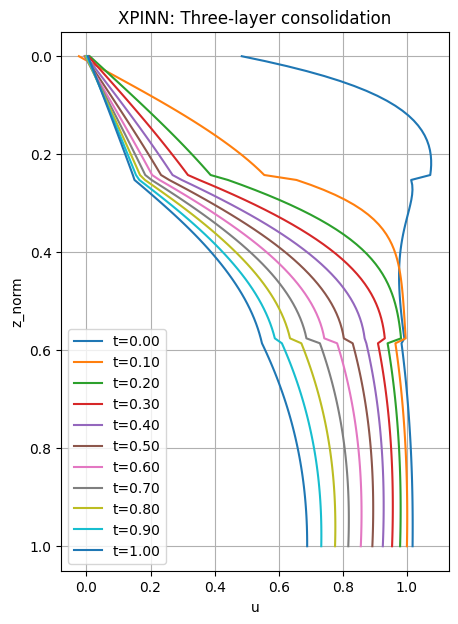

Epoch 2000: Residual Loss 1: 4.2577e-03, Residual Loss 2: 1.5151e-03, Residual Loss 3: 2.7575e-04, Boundary Loss 0: 8.3479e-04, Boundary Loss 1: 2.6434e-04, Initial Loss 1: 1.3007e-02, Initial Loss 2: 1.8094e-04, Initial Loss 3: 4.2400e-05, Interface Cont Loss 12: 4.3239e-04, Interface Flux Loss 12: 1.5423e-03, Interface Cont Loss 23: 4.0924e-04, Interface Flux Loss 23: 6.5470e-04, Total Loss: 3.0930e-02


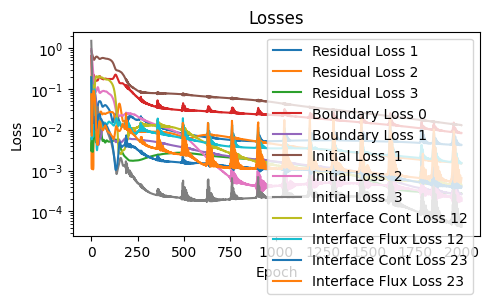

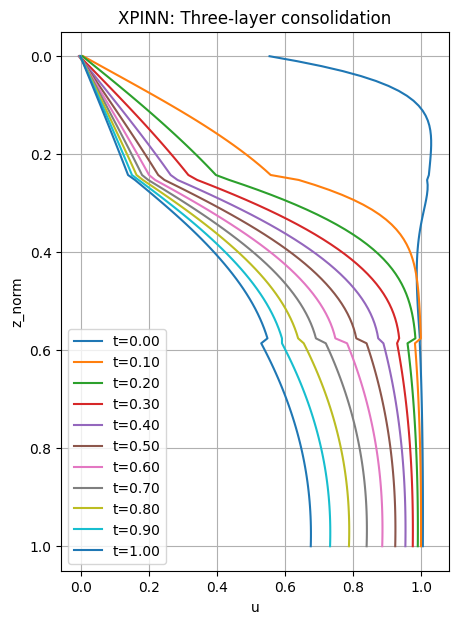

Epoch 2500: Residual Loss 1: 3.0674e-03, Residual Loss 2: 1.0102e-03, Residual Loss 3: 2.3404e-04, Boundary Loss 0: 4.8930e-04, Boundary Loss 1: 1.5946e-04, Initial Loss 1: 8.8723e-03, Initial Loss 2: 1.1969e-04, Initial Loss 3: 3.2053e-05, Interface Cont Loss 12: 3.8253e-04, Interface Flux Loss 12: 8.7592e-04, Interface Cont Loss 23: 3.0446e-04, Interface Flux Loss 23: 3.7497e-04, Total Loss: 2.0326e-02


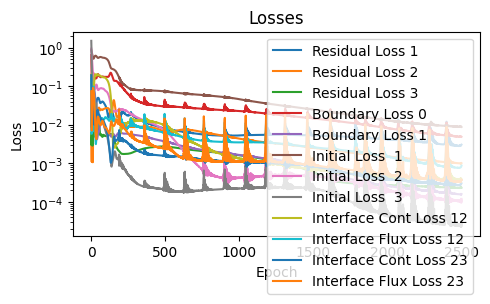

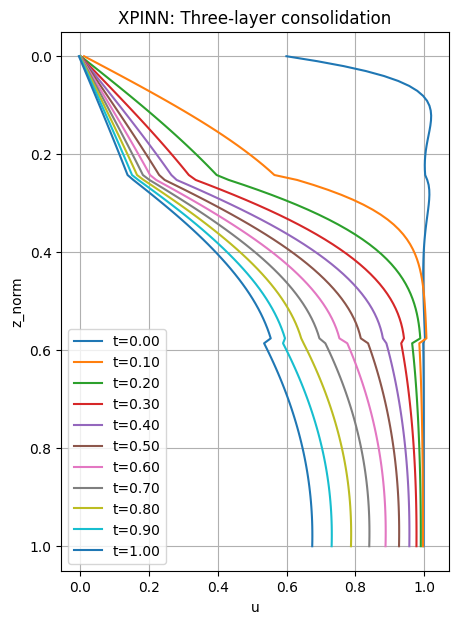

KeyboardInterrupt: 

In [854]:
for epoch in range(4001):
    optimizer_adam.zero_grad()
    # Compute losses
    pde_loss_1 = terzaghi_residual_1(model1_trick, domain_points_1, specs)
    pde_loss_2 = terzaghi_residual_2(model2_trick, domain_points_2, specs)
    pde_loss_3 = terzaghi_residual_3(model3_trick, domain_points_3, specs)
    boundary_loss_0 = terzaghi_boundary_0(model1_trick, boundary_points_b0)
    boundary_loss_1 = terzaghi_boundary_1(model3_trick, boundary_points_b1)
    initial_loss_1 = terzaghi_initial(model1_trick, initial_points_1)
    initial_loss_2 = terzaghi_initial(model2_trick, initial_points_2)
    initial_loss_3 = terzaghi_initial(model3_trick, initial_points_3)
    cont_loss_12, flux_loss_12 = terzaghi_interface_12(model1_trick, model2_trick, interface_points_12)
    cont_loss_23, flux_loss_23 = terzaghi_interface_23(model2_trick, model3_trick, interface_points_23)

    # Compute total loss
    total_loss = (pde_loss_1*w['pde1'] + 
                pde_loss_2*w['pde2'] + 
                pde_loss_3*w['pde3'] + 
                boundary_loss_0*w['b0'] + 
                boundary_loss_1*w['b1'] + 
                initial_loss_1*w['ic'] + 
                initial_loss_2*w['ic'] + 
                initial_loss_3*w['ic'] + 
                cont_loss_12*w['if_cont1'] +
                flux_loss_12*w['if_flux1'] +
                cont_loss_23*w['if_cont2'] +
                flux_loss_23*w['if_flux2'])
    current_loss = total_loss.item()
    if current_loss < best_loss:
        best_loss = current_loss

    # Backpropagation
    total_loss.backward()
    optimizer_adam.step()
    # Store losses
    losses["Residual Loss 1"].append(pde_loss_1.item()*w['pde1'])
    losses["Residual Loss 2"].append(pde_loss_2.item()*w['pde2'])
    losses["Residual Loss 3"].append(pde_loss_3.item()*w['pde3'])
    losses["Boundary Loss 0"].append(boundary_loss_0.item()*w['b0'])
    losses["Boundary Loss 1"].append(boundary_loss_1.item()*w['b1'])
    losses["Initial Loss  1"].append(initial_loss_1.item()*w['ic'])
    losses["Initial Loss  2"].append(initial_loss_2.item()*w['ic'])
    losses["Initial Loss  3"].append(initial_loss_3.item()*w['ic'])
    losses["Interface Cont Loss 12"].append(cont_loss_12.item()*w['if_cont1'])
    losses["Interface Flux Loss 12"].append(flux_loss_12.item()*w['if_flux1'])
    losses["Interface Cont Loss 23"].append(cont_loss_23.item()*w['if_cont2'])
    losses["Interface Flux Loss 23"].append(flux_loss_23.item()*w['if_flux2'])

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: "
            f"Residual Loss 1: {pde_loss_1.item():.4e}, "
            f"Residual Loss 2: {pde_loss_2.item():.4e}, "
            f"Residual Loss 3: {pde_loss_3.item():.4e}, "
            f"Boundary Loss 0: {boundary_loss_0.item():.4e}, "
            f"Boundary Loss 1: {boundary_loss_1.item():.4e}, "
            f"Initial Loss 1: {initial_loss_1.item():.4e}, "
            f"Initial Loss 2: {initial_loss_2.item():.4e}, "
            f"Initial Loss 3: {initial_loss_3.item():.4e}, "
            f"Interface Cont Loss 12: {cont_loss_12.item():.4e}, "
            f"Interface Flux Loss 12: {flux_loss_12.item():.4e}, "
            f"Interface Cont Loss 23: {cont_loss_23.item():.4e}, "
            f"Interface Flux Loss 23: {flux_loss_23.item():.4e}, "
            f"Total Loss: {total_loss.item():.4e}")
        plot_loss(losses)
        # Save the losses to a file
        np.save("loss_history.npy", losses)

        N_test=100
        # --- testing & plotting ---
        test_t = torch.linspace(0,1,11).view(-1,1)
        z_plot = torch.linspace(0,1,N_test).view(-1,1)

        plt.figure (figsize=(5, 7))
        for t in test_t:
            u_vals= []
            for z in z_plot:
                test_points = torch.cat([t.view(1,1), z.view(1,1), 
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1)
                                        ], dim=0).view(1,-1)
                with torch.no_grad():
                    if z.item()<=3/12:
                        u_vals.append(model1_trick(test_points).item())
                    elif z.item()<=7/12:
                        u_vals.append(model2_trick(test_points).item())
                    else:
                        u_vals.append(model3_trick(test_points).item())
            plt.plot(u_vals, z_plot.numpy(), label=f't={t.item():.2f}')

        plt.gca().invert_yaxis()
        plt.xlabel("u")
        plt.ylabel("z_norm")
        plt.title("XPINN: Three-layer consolidation")
        plt.legend()
        plt.grid(True)
        plt.show()

print(f"Phase 1 complete. Best loss so far: {best_loss:.4e}")

extra_epochs = 0
while True:
    extra_epochs += 1
    optimizer_adam.zero_grad()
    # Compute losses
    pde_loss_1 = terzaghi_residual_1(model1_trick, domain_points_1, specs)
    pde_loss_2 = terzaghi_residual_2(model2_trick, domain_points_2, specs)
    pde_loss_3 = terzaghi_residual_3(model3_trick, domain_points_3, specs)
    boundary_loss_0 = terzaghi_boundary_0(model1_trick, boundary_points_b0)
    boundary_loss_1 = terzaghi_boundary_1(model3_trick, boundary_points_b1)
    initial_loss_1 = terzaghi_initial(model1_trick, initial_points_1)
    initial_loss_2 = terzaghi_initial(model2_trick, initial_points_2)
    initial_loss_3 = terzaghi_initial(model3_trick, initial_points_3)
    cont_loss_12, flux_loss_12 = terzaghi_interface_12(model1_trick, model2_trick, interface_points_12)
    cont_loss_23, flux_loss_23 = terzaghi_interface_23(model2_trick, model3_trick, interface_points_23)

    # Compute total loss
    total_loss = (pde_loss_1*w['pde1'] + 
                pde_loss_2*w['pde2'] + 
                pde_loss_3*w['pde3'] + 
                boundary_loss_0*w['b0'] + 
                boundary_loss_1*w['b1'] + 
                initial_loss_1*w['ic'] + 
                initial_loss_2*w['ic'] + 
                initial_loss_3*w['ic'] + 
                cont_loss_12*w['if_cont1'] +
                flux_loss_12*w['if_flux1'] +
                cont_loss_23*w['if_cont2'] +
                flux_loss_23*w['if_flux2'])
    current_loss = total_loss.item()

    # Backpropagation
    total_loss.backward()
    optimizer_adam.step()

    # Store losses
    losses["Residual Loss 1"].append(pde_loss_1.item()*w['pde1'])
    losses["Residual Loss 2"].append(pde_loss_2.item()*w['pde2'])
    losses["Residual Loss 3"].append(pde_loss_3.item()*w['pde3'])
    losses["Boundary Loss 0"].append(boundary_loss_0.item()*w['b0'])
    losses["Boundary Loss 1"].append(boundary_loss_1.item()*w['b1'])
    losses["Initial Loss  1"].append(initial_loss_1.item()*w['ic'])
    losses["Initial Loss  2"].append(initial_loss_2.item()*w['ic'])
    losses["Initial Loss  3"].append(initial_loss_3.item()*w['ic'])
    losses["Interface Cont Loss 12"].append(cont_loss_12.item()*w['if_cont1'])
    losses["Interface Flux Loss 12"].append(flux_loss_12.item()*w['if_flux1'])
    losses["Interface Cont Loss 23"].append(cont_loss_23.item()*w['if_cont2'])
    losses["Interface Flux Loss 23"].append(flux_loss_23.item()*w['if_flux2'])

    if extra_epochs % 1000 == 0:
        print(f"Epoch {epoch}: "
            f"Residual Loss 1: {pde_loss_1.item():.4e}, "
            f"Residual Loss 2: {pde_loss_2.item():.4e}, "
            f"Residual Loss 3: {pde_loss_3.item():.4e}, "
            f"Boundary Loss 0: {boundary_loss_0.item():.4e}, "
            f"Boundary Loss 1: {boundary_loss_1.item():.4e}, "
            f"Initial Loss 1: {initial_loss_1.item():.4e}, "
            f"Initial Loss 2: {initial_loss_2.item():.4e}, "
            f"Initial Loss 3: {initial_loss_3.item():.4e}, "
            f"Interface Cont Loss 12: {cont_loss_12.item():.4e}, "
            f"Interface Flux Loss 12: {flux_loss_12.item():.4e}, "
            f"Interface Cont Loss 23: {cont_loss_23.item():.4e}, "
            f"Interface Flux Loss 23: {flux_loss_23.item():.4e}, "
            f"Total Loss: {total_loss.item():.4e}")
        plot_loss(losses)
        # Save the losses to a file
        np.save("loss_history.npy", losses)
    if current_loss < best_loss:
        print(f"New best loss: {current_loss:.4e}, after {extra_epochs} extra epochs")
        plot_loss(losses)
        np.save("loss_history.npy", losses)
        break

2500 epochs 10e2: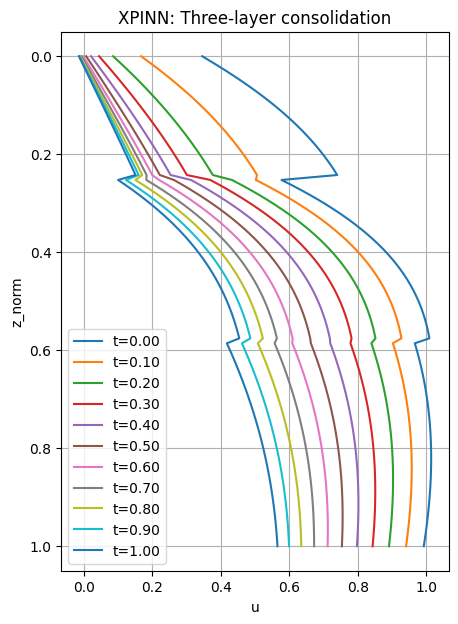
2500 epocyhs 10e3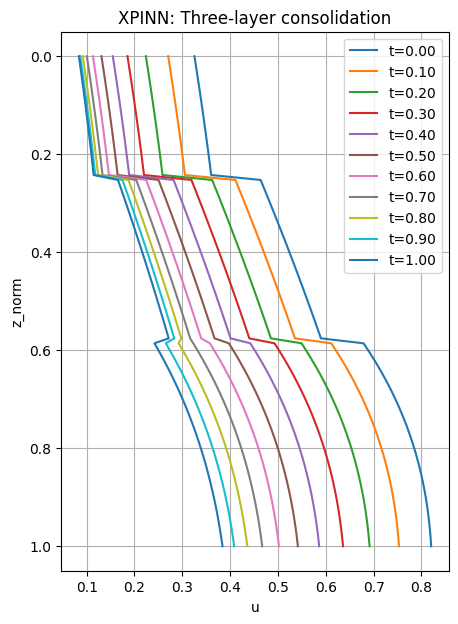
2500 epocyhs 10e1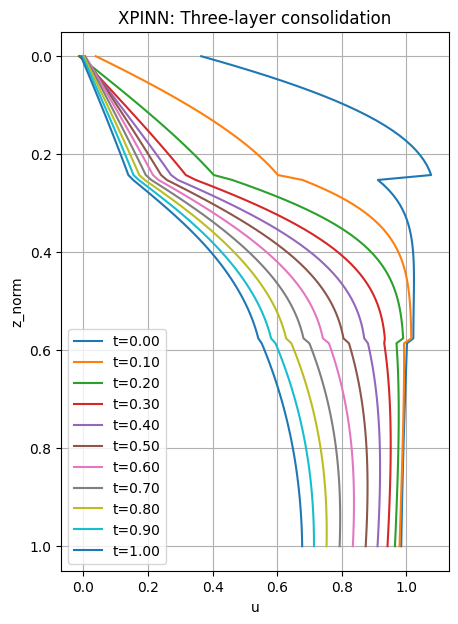

2500 10e0, all 1 except b0=10:
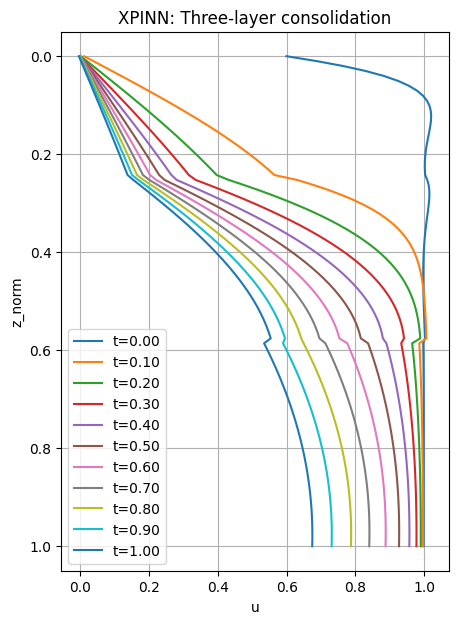

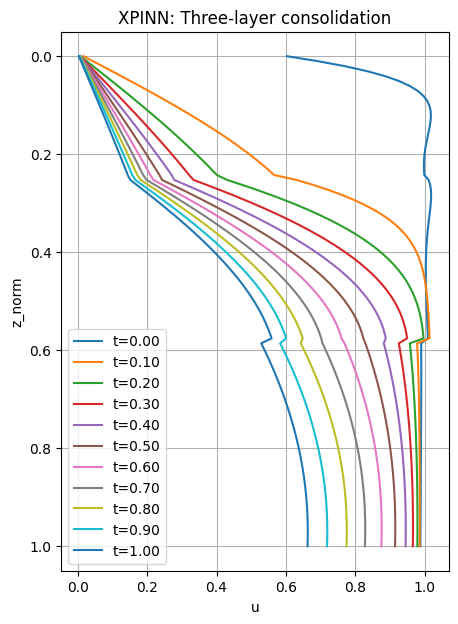

In [864]:
N=100
height_test = 0
k_test = .0
mv_test = -.0
H_test = 0.0

# --- testing & plotting ---
test_t = torch.linspace(0,1,11).view(-1,1)
z_plot = torch.linspace(0,1,N).view(-1,1)

plt.figure (figsize=(5, 7))
for t in test_t:
    u_vals= []
    # Vectorized version: create a batch of test_points for all z in z_plot
    z_batch = z_plot  # shape (N, 1)
    t_batch = t.repeat(z_batch.shape[0], 1)  # shape (N, 1)
    # Expand all other parameters to match z_batch shape
    height_batch = torch.full_like(z_batch, height_test)
    k_batch = torch.full_like(z_batch, k_test)
    mv_batch = torch.full_like(z_batch, mv_test)

    # Stack all input features for all z in z_plot
    test_points = torch.cat([
        t_batch, z_batch,
        height_batch, k_batch, mv_batch,
        height_batch, k_batch, mv_batch,
        height_batch, k_batch, mv_batch
    ], dim=1)  # shape (N, 11)

    with torch.no_grad():
        # Choose model for each z according to the same logic as before
        z_np = z_batch.squeeze().numpy()
        u_vals = torch.zeros_like(z_batch).squeeze()
        mask1 = z_np <= 3/12
        mask2 = (z_np > 3/12) & (z_np <= 7/12)
        mask3 = z_np > 7/12

        if mask1.any():
            u_vals[mask1] = model1_trick(test_points[mask1]).squeeze()
        if mask2.any():
            u_vals[mask2] = model2_trick(test_points[mask2]).squeeze()
        if mask3.any():
            u_vals[mask3] = model3_trick(test_points[mask3]).squeeze()

        u_vals = u_vals.numpy().tolist()

    plt.plot(u_vals, z_plot.numpy(), label=f't={t.item():.2f}')

plt.gca().invert_yaxis()
plt.xlabel("u")
plt.ylabel("z_norm")
plt.title("XPINN: Three-layer consolidation")
plt.legend()
plt.grid(True)
plt.show()

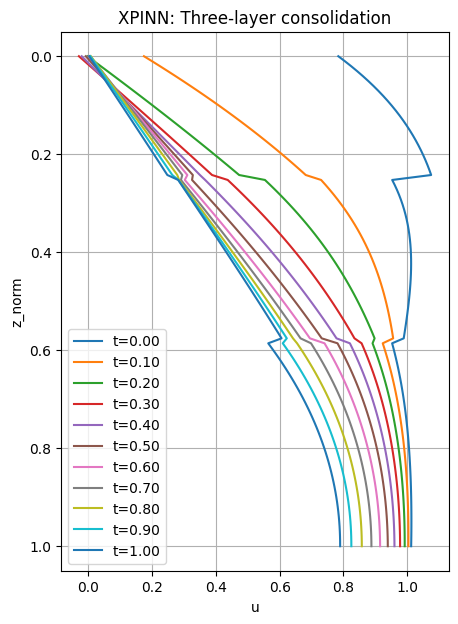

## Finite difference scheme

Δt = 5.560e-05 yr   →   Nt = 179,865 steps


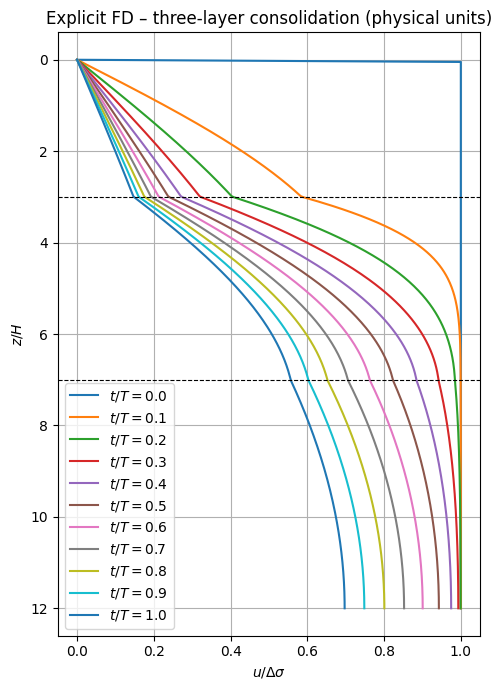

In [904]:
import numpy as np

def u_series(z, t, cv, H, n_terms=200):
    """
    Semi-analytical solution (Taylor 1942) for u(z,t) with
    drained top, impermeable bottom, uniform cv.
    z : array of depths [m]      (0 = top, H = bottom)
    t : scalar time [yr]
    cv: consolidation coefficient [m²/yr]
    H : drainage length [m]      (bottom is impermeable)
    """
    z = np.atleast_1d(z)
    series = np.zeros_like(z, dtype=float)
    fac = np.pi / (2*H)
    for n in range(n_terms):
        m   = 2*n + 1
        lam = m * fac
        series += (np.sin(lam * z) / m) * np.exp(-cv * m*m * np.pi**2 * t / (4*H*H))
    return (4/np.pi) * series


"""
Three-layer Terzaghi consolidation – explicit FD (physical units)
author : <your name>
date   : <yyyy-mm-dd>
"""

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1)  physical parameters
# -------------------------------------------------------------
height_test = .0
k_test = .0
mv_test = -.0

k1  = 2.0e-2 + 2e-3 * k_test    # m/yr
k2  = 6.0e-3 + 6e-4 * k_test
k3  = 3.0e-3 + 3e-4 * k_test
mv1 = 4.0e-4 + 4e-5 * mv_test     # m²/kN
mv2 = 6.0e-4 + 6e-5 * mv_test
mv3 = 7.0e-5 + 7e-6 * mv_test
H1 = 3 + 0.15 * height_test
H2 = 4 + 0.2 * height_test
H3 = 5 + 0.25 * height_test


# k1 = k2 = k3 = 2.0e-2
# mv1 = mv2 = mv3 = 4e-4
# H1 = 3.0
# H2 = 4.0
# H3 = 5.0

γw  = 9.81        # kN/m³
H   = H1 + H2 + H3       # m         (total thickness)
z1, z2 = H1, H2+H1                 # 3 m, 7 m is mean
T   = 10.0        # yr        (total time span)

# -------------------------------------------------------------
# 2)  spatial grid  z ∈ [0,H]  (physical metres)
# -------------------------------------------------------------
Nz   = 500
z    = np.linspace(0.0, H, Nz)
dz   = z[1] - z[0]

z1, z2 = H1, H2+H1                 # 3 m, 7 m is mean
idx1, idx2 = np.searchsorted(z, [z1, z2])

# layer-wise k(z) and m_v(z)
k_layer  = np.empty(Nz)
mv_layer = np.empty(Nz)

k_layer[:idx1]      = k1
k_layer[idx1:idx2]  = k2
k_layer[idx2:]      = k3

mv_layer[:idx1]     = mv1
mv_layer[idx1:idx2] = mv2
mv_layer[idx2:]     = mv3

# harmonic mean of k at faces
k_half = 2.0 * k_layer[:-1] * k_layer[1:] / (k_layer[:-1] + k_layer[1:])

# -------------------------------------------------------------
# 3)  explicit CFL time step
# -------------------------------------------------------------
cv_layer = k_layer / (mv_layer * γw)        # m²/yr
cv_max   = cv_layer.max()
dt       = 0.49 * dz**2 / cv_max           # yr   (≈ 2·10⁻⁵)
Nt       = int(np.ceil(T / dt)) + 1
print(f"Δt = {dt:.3e} yr   →   Nt = {Nt:,d} steps")

# times to record (years) and a lookup dict for fast checks
record_times  = np.linspace(0.0, T, 11)
record_steps  = {int(t/dt): t for t in record_times}
snapshots     = {}

# -------------------------------------------------------------
# 4)  initial & boundary conditions
# -------------------------------------------------------------
u = np.ones(Nz)
u[0]  = 0.0             # drained top: u = 0
u[-1] = u[-2]           # impermeable bottom: ∂u/∂z = 0

# -------------------------------------------------------------
# 5)  explicit time march
# -------------------------------------------------------------
for n in range(Nt):
    # Darcy flux  F[i+½] = k_half * (u[i+1]-u[i]) / dz
    F = k_half * (u[1:] - u[:-1]) / dz

    # update interior nodes  m_v γ_w ∂u/∂t = ∂F/∂z
    u_new = u.copy()
    u_new[1:-1] += (dt / (mv_layer[1:-1] * γw * dz)) * (F[1:] - F[:-1])

    # re-apply BCs
    u_new[0]  = 0.0
    u_new[-1] = u_new[-2]

    u = u_new

    # record snapshots
    if n in record_steps:
        snapshots[record_steps[n]] = u.copy()

# -------------------------------------------------------------
# 6)  plot
# -------------------------------------------------------------

# ------- comparison run for uniform material -----------------
# (skip if layers really differ and you only want the three-layer curves)
if k1 == k2 == k3 and mv1 == mv2 == mv3:
    cv  = k1 / (mv1 * γw)
    z_fine = np.linspace(0.0, H, 1000)
    plt.figure(figsize=(5,7))
    for t in record_times:
        ana = u_series(z_fine, t, cv, H)

        plt.plot(ana, z_fine,"--", lw=1, alpha=0.6)
        plt.plot(snapshots[t], z, label=rf'$t/T={t/T:.1f}$')
    plt.axhline(z1, color='k', ls='--', lw=0.8)
    plt.axhline(z2, color='k', ls='--', lw=0.8)
    plt.gca().invert_yaxis()
    plt.xlabel(r'$u/\Delta\sigma$')
    plt.ylabel(r'$z/H$')
    plt.title('Explicit FD – three-layer consolidation (physical units)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------- plot the three-layer solution ----------------------
else:
    plt.figure(figsize=(5,7))
    for t in record_times:
        plt.plot(snapshots[t], z, label=rf'$t/T={t/T:.1f}$')
    plt.axhline(z1, color='k', ls='--', lw=0.8)
    plt.axhline(z2, color='k', ls='--', lw=0.8)
    plt.gca().invert_yaxis()
    plt.xlabel(r'$u/\Delta\sigma$')
    plt.ylabel(r'$z/H$')
    plt.title('Explicit FD – three-layer consolidation (physical units)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [905]:
from scipy.integrate import simpson 
def total_settlement(u_vals, mv):

    z_vals = np.linspace(0, H, len(u_vals))
    
    # Effective stress = delta_sigma - u
    effective_stress = 1 - u_vals

    # Integrate effective stress over depth to get strain, then multiply by mv
    settlement = mv * simpson(effective_stress, x=z_vals)  # or np.trapz

    return settlement

In [906]:
total_settlement_1 = total_settlement(snapshots[record_times[10]], mv1)*100
print(total_settlement_1)

0.2777542494551543


In [ ]:
u_pred = []


# End

It: 0, Loss1: 3.398e+02, Loss2: 2.318e+00, Loss3: 1.359e+01, L2_err2: 1.064e+00, L2_err3: 1.047e+00
It: 20, Loss1: 2.741e+02, Loss2: 1.899e+00, Loss3: 1.259e+01, L2_err2: 1.062e+00, L2_err3: 9.574e-01
It: 40, Loss1: 1.863e+02, Loss2: 2.471e+00, Loss3: 1.287e+01, L2_err2: 6.897e-01, L2_err3: 7.309e-01
It: 60, Loss1: 8.981e+01, Loss2: 3.680e+00, Loss3: 1.553e+01, L2_err2: 1.433e-01, L2_err3: 3.249e-01
It: 80, Loss1: 4.685e+01, Loss2: 3.375e+00, Loss3: 1.569e+01, L2_err2: 6.595e-01, L2_err3: 1.854e-01
It: 100, Loss1: 3.600e+01, Loss2: 2.175e+00, Loss3: 1.390e+01, L2_err2: 7.577e-01, L2_err3: 2.061e-01
It: 120, Loss1: 3.161e+01, Loss2: 1.368e+00, Loss3: 1.340e+01, L2_err2: 8.023e-01, L2_err3: 2.675e-01
It: 140, Loss1: 2.926e+01, Loss2: 1.163e+00, Loss3: 1.289e+01, L2_err2: 7.978e-01, L2_err3: 3.048e-01
It: 160, Loss1: 2.745e+01, Loss2: 9.918e-01, Loss3: 1.080e+01, L2_err2: 7.733e-01, L2_err3: 3.064e-01
It: 180, Loss1: 2.501e+01, Loss2: 8.739e-01, Loss3: 7.096e+00, L2_err2: 7.021e-01, L2_er

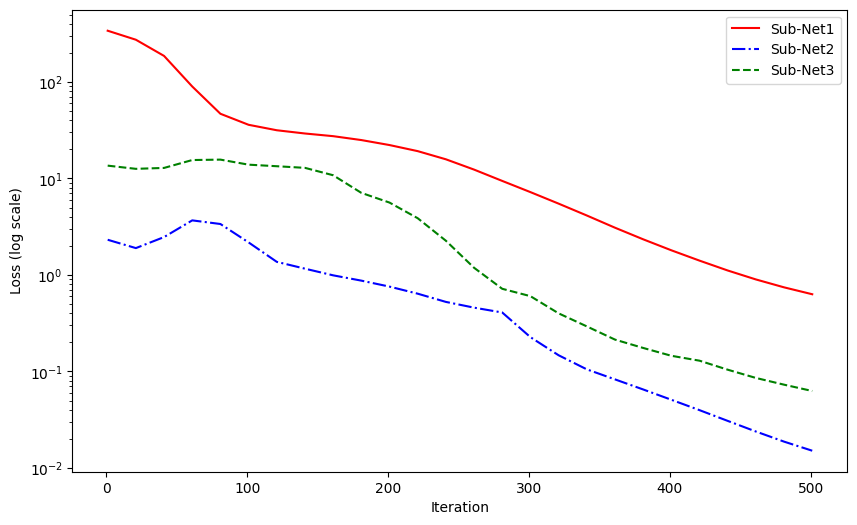

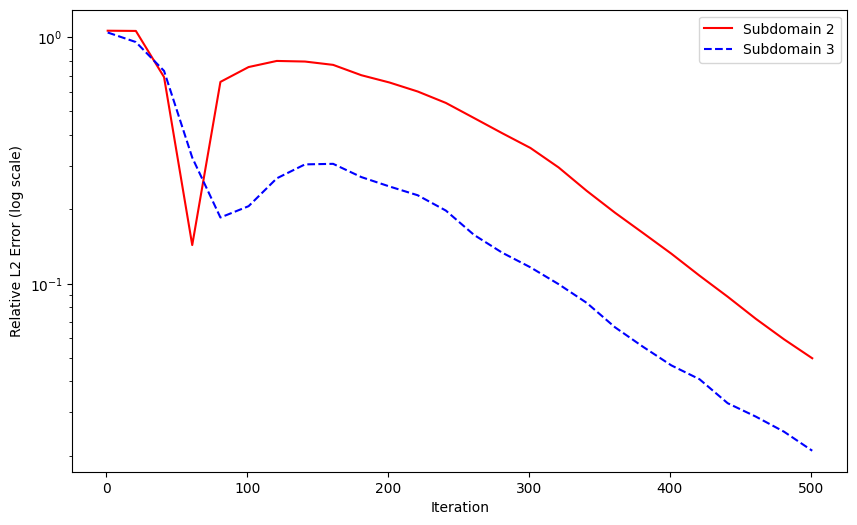

C:\Users\jolu2\AppData\Local\Temp\ipykernel_18332\1476462493.py:326: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))


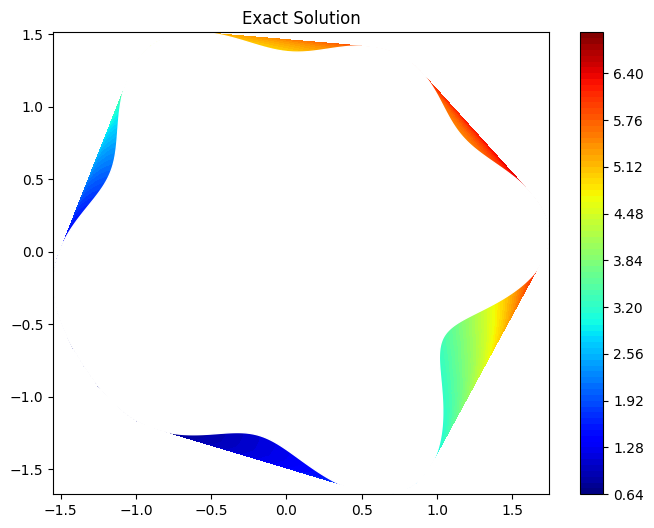

C:\Users\jolu2\AppData\Local\Temp\ipykernel_18332\1476462493.py:334: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))


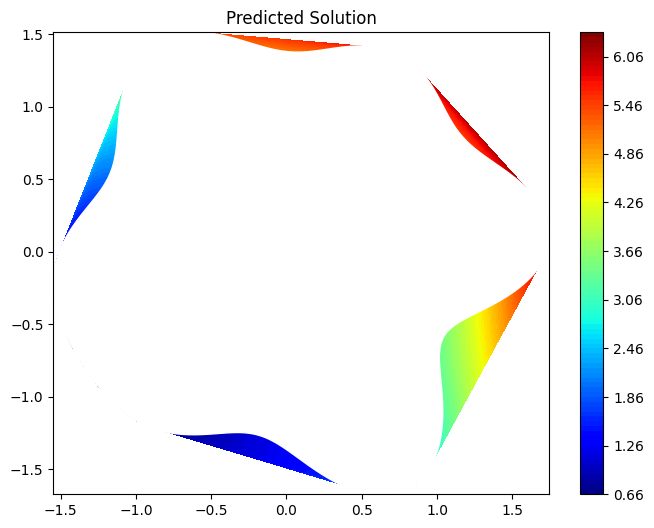

C:\Users\jolu2\AppData\Local\Temp\ipykernel_18332\1476462493.py:342: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))


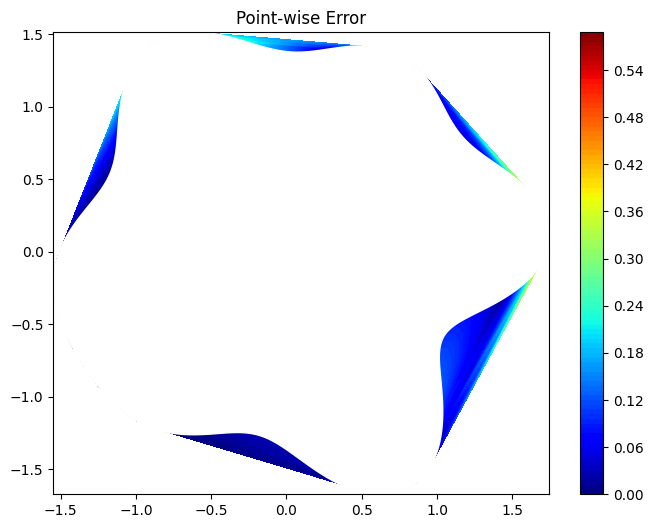

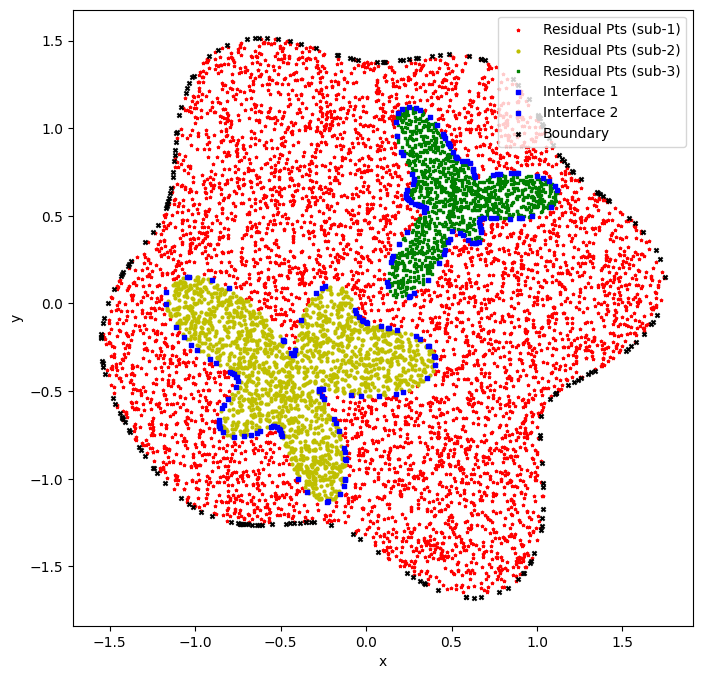

In [48]:
import sys
import time
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class MLP_Module(nn.Module):
    def __init__(self, layers, act='tanh'):
        super(MLP_Module, self).__init__()
        self.layers = layers
        self.linears = nn.ModuleList()
        self.A = nn.ParameterList()
        for i in range(len(layers)-1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
            # scale parameter for adaptive activation
            a = nn.Parameter(torch.tensor(0.05, dtype=torch.float64))
            self.A.append(a)
        self.act = act

    def forward(self, x):
        H = x
        for i, lin in enumerate(self.linears[:-1]):
            W_out = lin(H)
            scaled = 20.0 * self.A[i] * W_out
            if self.act == 'tanh':
                H = torch.tanh(scaled)
            elif self.act == 'sin':
                H = torch.sin(scaled)
            elif self.act == 'cos':
                H = torch.cos(scaled)
        # last layer
        Y = self.linears[-1](H)
        return Y

class XPINN:
    def __init__(self, X_ub, ub, X_f1, X_f2, X_f3, X_fi1, X_fi2,
                 layers1, layers2, layers3):
        # training data
        self.x_ub = torch.tensor(X_ub[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_ub = torch.tensor(X_ub[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.ub   = torch.tensor(ub, dtype=torch.float64, device=device)
        self.x_f1 = torch.tensor(X_f1[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_f1 = torch.tensor(X_f1[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_f2 = torch.tensor(X_f2[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_f2 = torch.tensor(X_f2[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_f3 = torch.tensor(X_f3[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_f3 = torch.tensor(X_f3[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_fi1 = torch.tensor(X_fi1[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_fi1 = torch.tensor(X_fi1[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_fi2 = torch.tensor(X_fi2[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_fi2 = torch.tensor(X_fi2[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        # nets
        self.net1 = MLP_Module(layers1, act='tanh').to(device)
        self.net2 = MLP_Module(layers2, act='sin').to(device)
        self.net3 = MLP_Module(layers3, act='cos').to(device)
        # optimizers
        self.opt1 = optim.Adam(self.net1.parameters(), lr=8e-4)
        self.opt2 = optim.Adam(self.net2.parameters(), lr=8e-4)
        self.opt3 = optim.Adam(self.net3.parameters(), lr=8e-4)

    def net_u1(self, x, y):
        return self.net1(torch.cat([x, y], dim=1))

    def net_u2(self, x, y):
        return self.net2(torch.cat([x, y], dim=1))

    def net_u3(self, x, y):
        return self.net3(torch.cat([x, y], dim=1))

    def net_f(self):
        # auto-diff for PDE residuals and interface conditions
        u1 = self.net_u1(self.x_f1, self.y_f1)
        grads1 = torch.autograd.grad(u1, [self.x_f1, self.y_f1],
                                     grad_outputs=torch.ones_like(u1), create_graph=True)
        u1_x, u1_y = grads1
        u1_xx = torch.autograd.grad(u1_x, self.x_f1, grad_outputs=torch.ones_like(u1_x), create_graph=True)[0]
        u1_yy = torch.autograd.grad(u1_y, self.y_f1, grad_outputs=torch.ones_like(u1_y), create_graph=True)[0]
        f1 = u1_xx + u1_yy - (torch.exp(self.x_f1) + torch.exp(self.y_f1))

        u2 = self.net_u2(self.x_f2, self.y_f2)
        grads2 = torch.autograd.grad(u2, [self.x_f2, self.y_f2],
                                     grad_outputs=torch.ones_like(u2), create_graph=True)
        u2_x, u2_y = grads2
        u2_xx = torch.autograd.grad(u2_x, self.x_f2, grad_outputs=torch.ones_like(u2_x), create_graph=True)[0]
        u2_yy = torch.autograd.grad(u2_y, self.y_f2, grad_outputs=torch.ones_like(u2_y), create_graph=True)[0]
        f2 = u2_xx + u2_yy - (torch.exp(self.x_f2) + torch.exp(self.y_f2))

        u3 = self.net_u3(self.x_f3, self.y_f3)
        grads3 = torch.autograd.grad(u3, [self.x_f3, self.y_f3],
                                     grad_outputs=torch.ones_like(u3), create_graph=True)
        u3_x, u3_y = grads3
        u3_xx = torch.autograd.grad(u3_x, self.x_f3, grad_outputs=torch.ones_like(u3_x), create_graph=True)[0]
        u3_yy = torch.autograd.grad(u3_y, self.y_f3, grad_outputs=torch.ones_like(u3_y), create_graph=True)[0]
        f3 = u3_xx + u3_yy - (torch.exp(self.x_f3) + torch.exp(self.y_f3))

        # interface 1
        u1i1 = self.net_u1(self.x_fi1, self.y_fi1)
        u2i1 = self.net_u2(self.x_fi1, self.y_fi1)
        grads1i1 = torch.autograd.grad(u1i1, [self.x_fi1, self.y_fi1], grad_outputs=torch.ones_like(u1i1), create_graph=True)
        u1i1_x, u1i1_y = grads1i1
        u1i1_xx = torch.autograd.grad(u1i1_x, self.x_fi1, grad_outputs=torch.ones_like(u1i1_x), create_graph=True)[0]
        u1i1_yy = torch.autograd.grad(u1i1_y, self.y_fi1, grad_outputs=torch.ones_like(u1i1_y), create_graph=True)[0]
        grads2i1 = torch.autograd.grad(u2i1, [self.x_fi1, self.y_fi1], grad_outputs=torch.ones_like(u2i1), create_graph=True)
        u2i1_x, u2i1_y = grads2i1
        u2i1_xx = torch.autograd.grad(u2i1_x, self.x_fi1, grad_outputs=torch.ones_like(u2i1_x), create_graph=True)[0]
        u2i1_yy = torch.autograd.grad(u2i1_y, self.y_fi1, grad_outputs=torch.ones_like(u2i1_y), create_graph=True)[0]
        fi1 = (u1i1_xx + u1i1_yy - (torch.exp(self.x_fi1) + torch.exp(self.y_fi1))) \
              - (u2i1_xx + u2i1_yy - (torch.exp(self.x_fi1) + torch.exp(self.y_fi1)))

        # interface 2
        u1i2 = self.net_u1(self.x_fi2, self.y_fi2)
        u3i2 = self.net_u3(self.x_fi2, self.y_fi2)
        grads1i2 = torch.autograd.grad(u1i2, [self.x_fi2, self.y_fi2], grad_outputs=torch.ones_like(u1i2), create_graph=True)
        u1i2_x, u1i2_y = grads1i2
        u1i2_xx = torch.autograd.grad(u1i2_x, self.x_fi2, grad_outputs=torch.ones_like(u1i2_x), create_graph=True)[0]
        u1i2_yy = torch.autograd.grad(u1i2_y, self.y_fi2, grad_outputs=torch.ones_like(u1i2_y), create_graph=True)[0]
        grads3i2 = torch.autograd.grad(u3i2, [self.x_fi2, self.y_fi2], grad_outputs=torch.ones_like(u3i2), create_graph=True)
        u3i2_x, u3i2_y = grads3i2
        u3i2_xx = torch.autograd.grad(u3i2_x, self.x_fi2, grad_outputs=torch.ones_like(u3i2_x), create_graph=True)[0]
        u3i2_yy = torch.autograd.grad(u3i2_y, self.y_fi2, grad_outputs=torch.ones_like(u3i2_y), create_graph=True)[0]
        fi2 = (u1i2_xx + u1i2_yy - (torch.exp(self.x_fi2) + torch.exp(self.y_fi2))) \
              - (u3i2_xx + u3i2_yy - (torch.exp(self.x_fi2) + torch.exp(self.y_fi2)))

        uavgi1 = 0.5*(u1i1 + u2i1)
        uavgi2 = 0.5*(u1i2 + u3i2)

        return f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2

    def loss(self, f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2):
        ub1_pred = self.net_u1(self.x_ub, self.y_ub)
        loss1 = 20*nn.MSELoss()(ub1_pred, self.ub) \
                + torch.mean(f1**2) + torch.mean(fi1**2) + torch.mean(fi2**2) \
                + 20*torch.mean((u1i1 - uavgi1)**2) + 20*torch.mean((u1i2 - uavgi2)**2)
        loss2 = torch.mean(f2**2) + torch.mean(fi1**2) + 20*torch.mean((u2i1 - uavgi1)**2)
        loss3 = torch.mean(f3**2) + torch.mean(fi2**2) + 20*torch.mean((u3i2 - uavgi2)**2)
        return loss1, loss2, loss3

    def train(self, nIter, X_star1, X_star2, X_star3, u_exact2, u_exact3):
        MSE_history1, MSE_history2, MSE_history3 = [], [], []
        l2_err2, l2_err3 = [], []
        u_exact2_t = torch.tensor(u_exact2, dtype=torch.float64, device=device)
        u_exact3_t = torch.tensor(u_exact3, dtype=torch.float64, device=device)
        for it in range(nIter):
            # compute residuals
            f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2 = self.net_f()
            # compute losses
            l1, l2, l3 = self.loss(f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2)

            # zero gradients
            self.opt1.zero_grad()
            self.opt2.zero_grad()
            self.opt3.zero_grad()
            # backward passes
            l1.backward(retain_graph=True)
            l2.backward(retain_graph=True)
            l3.backward()
            # optimizers step
            self.opt1.step()
            self.opt2.step()
            self.opt3.step()

            if it % 20 == 0:
                # full-domain predictions
                u1_full, u2_full, u3_full = self.predict(X_star1, X_star2, X_star3)
                # compute relative L2 errors on subdomains 2 & 3
                err2 = np.linalg.norm(u_exact2 - u2_full, 2)/np.linalg.norm(u_exact2, 2)
                err3 = np.linalg.norm(u_exact3 - u3_full, 2)/np.linalg.norm(u_exact3, 2)
                print(
                    f"It: {it}, Loss1: {l1.item():.3e}, Loss2: {l2.item():.3e}, Loss3: {l3.item():.3e}, " +
                    f"L2_err2: {err2:.3e}, L2_err3: {err3:.3e}"
                )
                MSE_history1.append(l1.item())
                MSE_history2.append(l2.item())
                MSE_history3.append(l3.item())
                l2_err2.append(err2)
                l2_err3.append(err3)
        return MSE_history1, MSE_history2, MSE_history3, l2_err2, l2_err3

    def predict(self, X_star1, X_star2, X_star3):
        x1 = torch.tensor(X_star1[:,0:1], dtype=torch.float64, device=device)
        y1 = torch.tensor(X_star1[:,1:2], dtype=torch.float64, device=device)
        x2 = torch.tensor(X_star2[:,0:1], dtype=torch.float64, device=device)
        y2 = torch.tensor(X_star2[:,1:2], dtype=torch.float64, device=device)
        x3 = torch.tensor(X_star3[:,0:1], dtype=torch.float64, device=device)
        y3 = torch.tensor(X_star3[:,1:2], dtype=torch.float64, device=device)
        u1 = self.net_u1(x1, y1).detach().cpu().numpy()
        u2 = self.net_u2(x2, y2).detach().cpu().numpy()
        u3 = self.net_u3(x3, y3).detach().cpu().numpy()
        return u1, u2, u3

# --------------------------------------------------------------------
if __name__ == '__main__':
    # Reproducibility
    set_seed(1234)
    # Use double precision for new layers
    torch.set_default_dtype(torch.float64)

    # Sampling parameters
    N_ub = 200
    N_f1 = 5000
    N_f2 = 1800
    N_f3 = 1200
    N_I1 = 100
    N_I2 = 100

    # Neural network architectures
    layers1 = [2, 30, 30, 1]
    layers2 = [2, 20, 20, 20, 20, 1]
    layers3 = [2, 25, 25, 25, 1]

    # Load data
    data = scipy.io.loadmat('./XPINN_2D_PoissonEqn.mat')
    x_f1 = data['x_f1'].flatten()[:, None]
    y_f1 = data['y_f1'].flatten()[:, None]
    x_f2 = data['x_f2'].flatten()[:, None]
    y_f2 = data['y_f2'].flatten()[:, None]
    x_f3 = data['x_f3'].flatten()[:, None]
    y_f3 = data['y_f3'].flatten()[:, None]
    xi1  = data['xi1'].flatten()[:, None]
    yi1  = data['yi1'].flatten()[:, None]
    xi2  = data['xi2'].flatten()[:, None]
    yi2  = data['yi2'].flatten()[:, None]
    xb   = data['xb'].flatten()[:, None]
    yb   = data['yb'].flatten()[:, None]

    ub_train  = data['ub'].flatten()[:, None]
    u_exact   = data['u_exact'].flatten()[:, None]
    u_exact2  = data['u_exact2'].flatten()[:, None]
    u_exact3  = data['u_exact3'].flatten()[:, None]

    # Full prediction points in each subdomain
    X_star1 = np.hstack((x_f1, y_f1))
    X_star2 = np.hstack((x_f2, y_f2))
    X_star3 = np.hstack((x_f3, y_f3))

    # Training inputs
    X_f1_train  = np.hstack((x_f1, y_f1))
    X_f2_train  = np.hstack((x_f2, y_f2))
    X_f3_train  = np.hstack((x_f3, y_f3))
    X_ub_train  = np.hstack((xb, yb))
    X_fi1_train = np.hstack((xi1, yi1))
    X_fi2_train = np.hstack((xi2, yi2))

    # Subsample points
    idx1 = np.random.choice(X_f1_train.shape[0], N_f1, replace=False)
    X_f1_train = X_f1_train[idx1, :]
    idx2 = np.random.choice(X_f2_train.shape[0], N_f2, replace=False)
    X_f2_train = X_f2_train[idx2, :]
    idx3 = np.random.choice(X_f3_train.shape[0], N_f3, replace=False)
    X_f3_train = X_f3_train[idx3, :]
    idx4 = np.random.choice(X_ub_train.shape[0], N_ub, replace=False)
    X_ub_train = X_ub_train[idx4, :]
    ub_train   = ub_train[idx4, :]
    idxi1 = np.random.choice(X_fi1_train.shape[0], N_I1, replace=False)
    X_fi1_train = X_fi1_train[idxi1, :]
    idxi2 = np.random.choice(X_fi2_train.shape[0], N_I2, replace=False)
    X_fi2_train = X_fi2_train[idxi2, :]

    # Instantiate and prepare model
    model = XPINN(X_ub_train, ub_train,
                  X_f1_train, X_f2_train, X_f3_train,
                  X_fi1_train, X_fi2_train,
                  layers1, layers2, layers3)
    # Ensure all sub-net parameters are float64
    model.net1.double()
    model.net2.double()
    model.net3.double()

    # Training
    Max_iter = 501
    start_time = time.time()
    MSE_hist1, MSE_hist2, MSE_hist3, l2_err2, l2_err3 = \
        model.train(Max_iter, X_star1, X_star2, X_star3, u_exact2, u_exact3)
    elapsed = time.time() - start_time
    print(f'Training time: {elapsed:.4f}')

    # Prediction
    u_pred1, u_pred2, u_pred3 = model.predict(X_star1, X_star2, X_star3)
    u_pred = np.vstack((u_pred1, u_pred2, u_pred3)).flatten()

    # Plot MSE history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Max_iter+1, 20), MSE_hist1, 'r-', label='Sub-Net1')
    plt.plot(range(1, Max_iter+1, 20), MSE_hist2, 'b-.', label='Sub-Net2')
    plt.plot(range(1, Max_iter+1, 20), MSE_hist3, 'g--', label='Sub-Net3')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Plot L2 error history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Max_iter+1, 20), l2_err2, 'r-', label='Subdomain 2')
    plt.plot(range(1, Max_iter+1, 20), l2_err3, 'b--', label='Subdomain 3')
    plt.xlabel('Iteration')
    plt.ylabel('Relative L2 Error (log scale)')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Concatenate coordinates for triangulation
    x_tot = np.concatenate((x_f1, x_f2, x_f3))
    y_tot = np.concatenate((y_f1, y_f2, y_f3))
    triang_total = tri.Triangulation(x_tot.flatten(), y_tot.flatten())

    # Plot exact solution contour
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang_total, u_exact.flatten(), 100, cmap='jet')
    XX = np.vstack((np.hstack((xb, yb)), np.hstack((xi2, yi2)), np.array([[xb[-1,0], yb[-1,0]]])))
    plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))
    plt.colorbar()
    plt.title('Exact Solution')
    plt.show()

    # Plot predicted solution contour
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang_total, u_pred, 100, cmap='jet')
    plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))
    plt.colorbar()
    plt.title('Predicted Solution')
    plt.show()

    # Plot point-wise error contour
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang_total, np.abs(u_exact.flatten() - u_pred), 100, cmap='jet')
    plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))
    plt.colorbar()
    plt.title('Point-wise Error')
    plt.show()

    # Scatter data points
    plt.figure(figsize=(8, 8))
    plt.scatter(X_f1_train[:,0], X_f1_train[:,1], c='r', s=4, marker='*', label='Residual Pts (sub-1)')
    plt.scatter(X_f2_train[:,0], X_f2_train[:,1], c='y', s=4, marker='o', label='Residual Pts (sub-2)')
    plt.scatter(X_f3_train[:,0], X_f3_train[:,1], c='g', s=4, marker='s', label='Residual Pts (sub-3)')
    plt.scatter(X_fi1_train[:,0], X_fi1_train[:,1], c='b', s=7, marker='s', label='Interface 1')
    plt.scatter(X_fi2_train[:,0], X_fi2_train[:,1], c='b', s=7, marker='s', label='Interface 2')
    plt.scatter(X_ub_train[:,0], X_ub_train[:,1], c='k', s=9, marker='x', label='Boundary')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
